# **Towards differentiating between failures and domain shifts in industrial data streams**




In [1]:
import numpy as np
import pandas as pd
from focal_loss import BinaryFocalLoss
import shap
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from scipy.stats import norm, multivariate_normal
from scipy.spatial import cKDTree as KDTree


from adapt.feature_based import CCSA
import tensorflow as tf
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Input, Dense, Reshape,Layer, Dropout, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
import keras.backend as K

from river.drift import PageHinkley
from river import stream
from river import compose

from imblearn.metrics import geometric_mean_score

warnings.filterwarnings("ignore")
pd.options.display.max_columns = 50


2024-06-05 06:00:57.765600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 06:00:58.361582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
def split_dataframes_based_on_drift(X: pd.DataFrame,
                                    changes: list):
  list_of_change = changes.copy()
  split_dataframes = []
  start_index = 0
  end_index = 0
  list_of_change.append(len(X))
  if len(changes) < 1:
    return X
  else:
    for i in range(len(list_of_change)):
      end_index = list_of_change[i]
      split_dataframes.append(X[start_index:end_index])
      start_index=end_index
    return split_dataframes

In [3]:
def KLdivergence(x, y):
  """Compute the Kullback-Leibler divergence between two multivariate samples.
  Parameters
  ----------
  x : 2D array (n,d)
    Samples from distribution P, which typically represents the true
    distribution.
  y : 2D array (m,d)
    Samples from distribution Q, which typically represents the approximate
    distribution.
  Returns
  -------
  out : float
    The estimated Kullback-Leibler divergence D(P||Q).
  References
  ----------
  Pérez-Cruz, F. Kullback-Leibler divergence estimation of
continuous distributions IEEE International Symposium on Information
Theory, 2008.
  """


  # Check the dimensions are consistent
  x = np.atleast_2d(x)
  y = np.atleast_2d(y)

  n,d = x.shape
  m,dy = y.shape

  assert(d == dy)


  # Build a KD tree representation of the samples and find the nearest neighbour
  # of each point in x.
  xtree = KDTree(x)
  ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
  r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
  s = ytree.query(x, k=1, eps=.01, p=2)[0]

  # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
  # on the first term of the right hand side.
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

In [4]:
def distribution_drift_detection(X: pd.DataFrame,
                                 referance_samples = 100, 
                                 x_cols = ["x", "y"],
                                 min_instances=10,
                                 delta=0.05,
                                 threshold=4,
                                 alpha=0.9999,
                                 save=False
                                 
                                ):

    reference_distribution = X[x_cols][:referance_samples].values 
    X["KL"] = -1
    stream_change = []
    ph = PageHinkley(min_instances=min_instances, delta=delta, threshold=threshold, alpha=alpha)
    start_drift = 2
    referance_indx_start = referance_indx_end =  0
    
    for i in range(referance_samples, len(X)):
        sample =  X[x_cols].loc[i].values 
        kl_divergence = KLdivergence(reference_distribution, sample)
        X["KL"].loc[i] = kl_divergence
        ph.update(kl_divergence)
        if ph.drift_detected:
          stream_change.append(i)
          start_drift = i
          reference_distribution = X[x_cols][start_drift-2:i].values

        else:
            reference_distribution = X[x_cols][start_drift-2:i].values
    
    custom_colors =  ["darkblue", "orangered", "darkgreen", "purple", "saddlebrown", "dimgrey"]
    custom_colors =  ["orangered", "tab:green", "tab:red", "tab:blue", "tab:grey", "dimgrey"]

    print(f"Changes detected in samples: {stream_change}")
    X_plot = X[referance_samples:]
    plt.figure(figsize=(15,6))
    for i in range(len(X_plot['cluster'].unique())):
        cluster = X_plot['cluster'].unique()[i]
        subset = X_plot[X_plot['cluster'] == cluster]
        plt.scatter(subset.index, subset['KL'], c=custom_colors[i], edgecolor="k", label=f'Domain {i+1}')

    plt.axvline(x = stream_change[0], color = "#c73213", label = 'Detected change')
    for idx in stream_change:
        plt.axvline(x = idx, color = "#c73213")
    plt.ylabel("KL Divergence")
    plt.xlabel("instance")
    plt.title(f"Changes detected in samples: {stream_change}")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.legend(loc='best')
    plt.grid()
    if save:
        plt.savefig(f"ECAI code/figures/KL.pdf", format="pdf", bbox_inches="tight")
    plt.show()



    return stream_change
        

# DATA FROM SIMULATOR

In [5]:
df=pd.read_csv('ECAI code/dataset_simulator_ecai.csv', index_col=[0])

In [6]:
df["Reduction"] = df["Anomaly_Reduction"].map(lambda x: 0 if x==False else 1)
anomaly_cols = ["Reduction"]  
for col in ['Anomaly_Electric_1', 'Anomaly_Bearing_1', 'Anomaly_WorkRoll_1',
       'Anomaly_Electric_2', 'Anomaly_Bearing_2', 'Anomaly_WorkRoll_2',
       'Anomaly_Electric_3', 'Anomaly_Bearing_3', 'Anomaly_WorkRoll_3',
       'Anomaly_Electric_4', 'Anomaly_Bearing_4', 'Anomaly_WorkRoll_4']:
    df[col[8:]] = df[col].map(lambda x: 0 if x==0 else 1)
    anomaly_cols.append(col[8:])


any_anomaly = []
for i in range(len(df[anomaly_cols])):
    if df[anomaly_cols].loc[i].max() == 0:
        any_anomaly.append(0)
    else:
        any_anomaly.append(1)

df["class"] = any_anomaly

In [7]:
x_cols = ['ithick', 'othick', 'width', 'ys0', 'ys1', 'work_roll_diam_1',
       'work_roll_diam_2', 'work_roll_diam_3', 'work_roll_diam_4',
       'work_roll_mileage_1', 'work_roll_mileage_2', 'work_roll_mileage_3',
       'work_roll_mileage_4', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'tension_1', 'tension_2', 'tension_3', 'tension_4',
       'tension_5', 'roll_speed_1', 'roll_speed_2', 'roll_speed_3',
       'roll_speed_4', 'force_1', 'force_2', 'force_3', 'force_4', 'torque_1',
       'torque_2', 'torque_3', 'torque_4', 'gap_1', 'gap_2', 'gap_3', 'gap_4',
       'current_1', 'current_2', 'current_3', 'current_4']


all_cols =  x_cols + ['class']
X_data = df[all_cols]


cols_for_scale = ['ys0', 'ys1', 'work_roll_diam_1',
       'work_roll_diam_2', 'work_roll_diam_3', 'work_roll_diam_4',
       'work_roll_mileage_1', 'work_roll_mileage_2', 'work_roll_mileage_3',
       'work_roll_mileage_4', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'tension_1', 'tension_2', 'tension_3', 'tension_4',
       'tension_5', 'roll_speed_1', 'roll_speed_2', 'roll_speed_3',
       'roll_speed_4', 'force_1', 'force_2', 'force_3', 'force_4', 'torque_1',
       'torque_2', 'torque_3', 'torque_4', 'gap_1', 'gap_2', 'gap_3', 'gap_4',
       'current_1', 'current_2', 'current_3', 'current_4']

X_for_scale = df[cols_for_scale]

In [8]:
scaler = StandardScaler()

df_scaled = scaler.fit_transform(X_for_scale.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=X_for_scale.columns)

In [9]:
X = X_data.copy()
X[X_for_scale.columns] = df_scaled

In [10]:
X["ithick"].value_counts()

ithick
3.4    8000
3.0    1000
2.8     500
3.5     500
Name: count, dtype: int64

In [11]:
x_cols = ['ys0', 'ys1', 'work_roll_diam_1',
       'work_roll_diam_2', 'work_roll_diam_3', 'work_roll_diam_4',
       'work_roll_mileage_1', 'work_roll_mileage_2', 'work_roll_mileage_3',
       'work_roll_mileage_4', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'tension_1', 'tension_2', 'tension_3', 'tension_4',
       'tension_5', 'roll_speed_1', 'roll_speed_2', 'roll_speed_3',
       'roll_speed_4', 'force_1', 'force_2', 'force_3', 'force_4', 'torque_1',
       'torque_2', 'torque_3', 'torque_4', 'gap_1', 'gap_2', 'gap_3', 'gap_4',
       'current_1', 'current_2', 'current_3', 'current_4']

In [12]:
cluster = list(np.ones(8000)) + list(2*np.ones(500)) + list(3*np.ones(500)) + list(4*np.ones(500)) + list(5*np.ones(500)) 
X["cluster"]=cluster

Changes detected in samples: [8010, 8550, 9042, 9515]


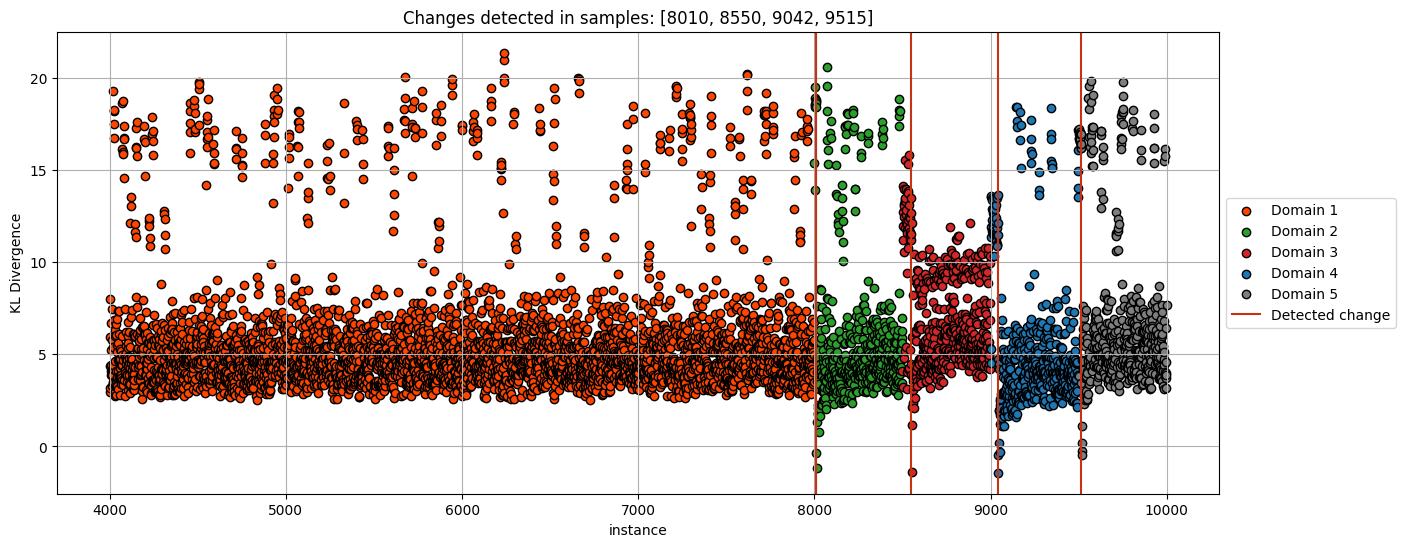

In [13]:
stream_change = distribution_drift_detection(X, referance_samples = 4000, x_cols = ["current_1", "torque_1", "current_2", "torque_2", "current_3", "torque_3", "current_4", "torque_4"],
                                                 min_instances=1, delta=0.005, threshold=425, alpha=0.9999, save=False)

In [14]:
def getshap_barplot(X, columns, model, plot=False):
  #datadf = pd.DataFrame(X, columns=columns)
  #datadf['class'] = y
  #model.predict(X)
  explainer = shap.Explainer(model, X, feature_names=columns)
  shap_values = explainer(X)
  expected_values=[np.mean(v) for v in shap_values.values]
  if plot:
    shap.plots.bar(shap_values, X)
  return explainer, shap_values

In [15]:
def stream_domain_adaptation(X:pd.DataFrame,
                             ccsa_enc,
                             ccsa_task,
                             stream_change,
                             batch_size,     
                             filepath,
                             x_cols = ["x", "y"],
                             y_col = ["class"]):


  


  print("---------------STREAMING LEARNING---------------")

  result_info = pd.DataFrame()
  df_pred_da = pd.DataFrame()
  sv_previous = []
  df_shap_batches = pd.DataFrame()
  df_shap_next_batches = pd.DataFrame()
  split_X = split_dataframes_based_on_drift(X, stream_change)
  data_source = split_X[0]
  print(f"CHANGES: {stream_change}")
  Xs = data_source[x_cols]
  ys = data_source[y_col].values
  training = 0


  stream_change.append(len(X))

 





  print("--------------- DOMAIN ADAPTATION - BATCHES ---------------")


  for i in range(0, len(split_X)-1):
    print(f"ITERATION : {i}")
    print(f"----------------------------------------")
    print(f"data source shape : {data_source.shape}")
    data_target = split_X[i+1]
    Xt = data_target[x_cols]
    yt = data_target[y_col].values
    print(f"Xt shape: {Xt.shape}, yt shape: {yt.shape}")

  
    start_batch = stream_change[i]
    end_batch = start_batch + batch_size
    next_stream_change = stream_change[i+1]
    print(f"START_BATCH: {start_batch}, END_BATCH: {end_batch}, NEXT_CHANGE: {next_stream_change}")
    batch_training = 0  
    f1_source = 0
    da_retraining = 0


    while end_batch < next_stream_change:

      Xt_batch = X[x_cols][start_batch:end_batch]
      yt_batch = X[y_col][start_batch:end_batch].values
      print(f"X_source {Xs.shape}, y_source: {ys.shape}")
      print(f"X_target_batch {Xt_batch.shape}, y_target_batch: {yt_batch.shape}")
      print(f"start_X_target_batch_index: {start_batch}, end: {end_batch}")
      #display(result_info)
      #INIT_LR = 0.001 
      #alpha = 0.25
      #gamma = 20
      #BATCH_SIZE = 128
      #EPOCHS = 500
      INIT_LR = 0.0001 
      alpha = 0.75
      gamma = 2
      BATCH_SIZE = 128
      EPOCHS = 500
      decay=INIT_LR / EPOCHS
      model = CCSA(ccsa_enc, ccsa_task, Xt=Xt_batch, yt=yt_batch, metrics=["acc"], 
               loss=BinaryFocalCrossentropy(gamma=gamma,  apply_class_balancing=True, alpha=alpha), 
               random_state=0, optimizer=Adam(learning_rate=INIT_LR, clipvalue=0.5))

      model.compile()
      f1_source = 0
      da_retraining = 0


      while (f1_source < 0.5 and (da_retraining<5)):
          model.fit(X=Xs, y=ys, Xt=Xt_batch, yt=yt_batch, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
          y_predict_source = model.predict(Xs)[:,0]
          y_predict_source = list(map(lambda x: 1 if x>0.5 else 0, y_predict_source))
          f1_source = f1_score(y_predict_source, ys)
          print(f"f1 source : {f1_source}, training: {da_retraining}")
          da_retraining += 1
          
      #print("TRAINING RESULT on batch")
      #display(confusion_matrix(yt_batch, np.round(model.predict(Xt_batch))))
      ex1,sv1=getshap_barplot(Xt_batch.values, x_cols, model)
      df_sv_batch = pd.DataFrame(sv1.values, index=Xt_batch.index, columns=x_cols)
      df_sv_batch.to_csv(f"{filepath}/sv_batch_{training}.csv")
      df_shap_batches = pd.concat([df_shap_batches, df_sv_batch])
     
     
      training = training + 1
      next_batch = end_batch + batch_size

      if next_batch < next_stream_change:

        

        Xt_next_batch = X[x_cols][end_batch:next_batch]
        yt_next_batch = X[y_col][end_batch:next_batch].values
        print(f"Xt_next_batch {Xt_next_batch.shape}, yt_next_batch: {yt_next_batch.shape}")
        y_predict_next_batch = model.predict(Xt_next_batch)[:,0]
        sv_next_batch = ex1(Xt_next_batch.values)
        df_sv_next_batch = pd.DataFrame(sv_next_batch.values, index=Xt_next_batch.index, columns=x_cols)
        df_sv_next_batch.to_csv(f"{filepath}/sv_next_batch_{training}.csv")
        df_shap_next_batches = pd.concat([df_shap_next_batches, df_sv_next_batch])

          

        y_predict_next_batch = list(map(lambda x: 1 if x>0.5 else 0, y_predict_next_batch))
        df_pred = pd.DataFrame(data=y_predict_next_batch, columns=["y_pred_da"], index=Xt_next_batch.index)
        df_pred_da = pd.concat([df_pred_da, df_pred])
        print(f"y_predict_next_batch: {len(y_predict_next_batch)}")

        df_result = pd.DataFrame(data={
                          "data_source" : ['1'],
                          "data_target" : [f"{i+2}"],
                          "start_batch_fit" : [start_batch],
                          "end_batch_fit" : [end_batch],
                          "start_batch_predict" : [end_batch],
                          "end_batch_predict" : [end_batch + len(y_predict_next_batch)],
                          "len batch predicted" :  [len(y_predict_next_batch)],
                          "f1_da" : [f1_score(yt_next_batch, y_predict_next_batch)],
                          "G_da" : [geometric_mean_score(yt_next_batch, y_predict_next_batch, average='binary')],
                          "accuracy_da" : [accuracy_score(yt_next_batch, y_predict_next_batch)],  
                          "recall_da" : [recall_score(yt_next_batch, y_predict_next_batch)],

                          })

        result_info = pd.concat([result_info, df_result])

        #start_batch = end_batch
        end_batch = next_batch

      else:
        
        Xt_next_batch = X[x_cols][end_batch:next_stream_change]
        yt_next_batch = X[y_col][end_batch:next_stream_change].values
        print(f'X_next_batch shape: {Xt_next_batch.shape}')
        y_predict_next_batch= model.predict(Xt_next_batch)[:,0]
          
        y_predict_next_batch = list(map(lambda x: 1 if x>0.5 else 0, y_predict_next_batch))
        df_pred = pd.DataFrame(data=y_predict_next_batch, columns=["y_pred_da"], index=Xt_next_batch.index)
        df_pred_da = pd.concat([df_pred_da, df_pred])
       
        df_result = pd.DataFrame(data={
                          "data_source" : ['1'],
                          "data_target" : [f"{i+2}"],
                          "start_batch_fit" : [start_batch],
                          "end_batch_fit" : [end_batch],
                          "start_batch_predict" : [end_batch],
                          "end_batch_predict" : [end_batch + len(y_predict_next_batch)],
                          "len batch predicted" :  [len(y_predict_next_batch)],
                          "f1_da" : [f1_score(yt_next_batch, y_predict_next_batch)],
                          "G_da" : [geometric_mean_score(yt_next_batch, y_predict_next_batch, average='binary')],
                          "accuracy_da" : [accuracy_score(yt_next_batch, y_predict_next_batch)],  
                          "recall_da" : [recall_score(yt_next_batch, y_predict_next_batch)],

                          })

        result_info = pd.concat([result_info, df_result])
        break


   
    df_true = pd.DataFrame(data=X[y_col].values, columns=["y_true"], index=X.index)
    df_stream_da = pd.merge(df_pred_da, df_true, left_index=True, right_index=True)



    

  return result_info, df_stream_da, df_shap_batches, df_shap_next_batches

In [16]:
x_cols = ['work_roll_diam_1',
       'work_roll_diam_2', 'work_roll_diam_3', 'work_roll_diam_4',
       'work_roll_mileage_1', 'work_roll_mileage_2', 'work_roll_mileage_3',
       'work_roll_mileage_4', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'tension_1', 'tension_2', 'tension_3', 'tension_4',
       'tension_5', 'roll_speed_1', 'roll_speed_2', 'roll_speed_3',
       'roll_speed_4', 'force_1', 'force_2', 'force_3', 'force_4', 'torque_1',
       'torque_2', 'torque_3', 'torque_4', 'gap_1', 'gap_2', 'gap_3', 'gap_4',
       'current_1', 'current_2', 'current_3', 'current_4']

In [17]:
def get_encoder(input_shape=(X[x_cols].shape[1],)):
    model = Sequential()
    model.add(Dense(100, activation='relu',
                    input_shape=input_shape))
    model.add(Dense(10, activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(2, activation="sigmoid"))
    #model.add(Dense(X[x_cols].shape[1], activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.00001), loss=BinaryFocalLoss(gamma=10))
    return model

def get_task(input_shape=(X[x_cols].shape[1],)):
    model = Sequential()
    model.add(Dense(10, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.00001), loss=BinaryFocalLoss(gamma=10))
    return model

ccsa_enc = get_encoder()
ccsa_task = get_task()

2024-06-05 06:03:11.845151: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-05 06:03:11.845171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 9bb3b33373ff
2024-06-05 06:03:11.845175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 9bb3b33373ff
2024-06-05 06:03:11.845335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.86.10
2024-06-05 06:03:11.845346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.86.10
2024-06-05 06:03:11.845349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.86.10


In [18]:
stream_change

[8010, 8550, 9042, 9515]

In [19]:
X = X[x_cols + ["class"]]
split_X = split_dataframes_based_on_drift(X, stream_change)

y_col = "class"
data_source = split_X[0]
Xs = data_source[x_cols]
ys = data_source[[y_col]]

data_target_1 = split_X[1] #product data
Xt_1 = data_target_1[x_cols]
yt_1 = data_target_1[[y_col]]

data_target_2 = split_X[2] #failure data
Xt_2 = data_target_2[x_cols]
yt_2 = data_target_2[[y_col]].map(lambda x: 1 if x==0 else 0) #simulation of failure 


data_target_3 = split_X[3] #product data
Xt_3 = data_target_3[x_cols]
yt_3 = data_target_3[y_col]


data_target_4 = split_X[4] #product data
Xt_4 = data_target_4[x_cols]
yt_4 = data_target_4[y_col]

In [20]:
X_change = pd.concat([pd.concat([Xs,ys], axis=1), 
                      pd.concat([Xt_1, yt_1], axis=1), 
                      pd.concat([Xt_2, yt_2], axis=1),
                     pd.concat([Xt_3, yt_3], axis=1),
                     pd.concat([Xt_4, yt_4], axis=1)])

In [21]:
# uncomment if you want to run the experiment 



"""filepath = "ECAI code/results"


result_info, df_stream_da, df_shap_batches, df_shap_next_batches = stream_domain_adaptation(X_change,
                             ccsa_enc,
                             ccsa_task,
                             stream_change = stream_change,
                             batch_size = 50,      
                             x_cols = x_cols,
                             y_col = ["class"],
                             filepath= filepath)


filepath = "ECAI code/results"
result_info.to_csv(f"{filepath}/result_info.csv")
df_shap_next_batches.to_csv(f"{filepath}/df_shap_next_batches.csv")
df_shap_batches.to_csv(f"{filepath}/df_shap_batches.csv")
df_stream_da.to_csv(f"{filepath}/df_stream_da.csv")"""

'filepath = "ECAI code/results"\n\n\nresult_info, df_stream_da, df_shap_batches, df_shap_next_batches = stream_domain_adaptation(X_change,\n                             ccsa_enc,\n                             ccsa_task,\n                             stream_change = stream_change,\n                             batch_size = 50,      \n                             x_cols = x_cols,\n                             y_col = ["class"],\n                             filepath= filepath)\n\n\nfilepath = "ECAI code/results"\nresult_info.to_csv(f"{filepath}/result_info.csv")\ndf_shap_next_batches.to_csv(f"{filepath}/df_shap_next_batches.csv")\ndf_shap_batches.to_csv(f"{filepath}/df_shap_batches.csv")\ndf_stream_da.to_csv(f"{filepath}/df_stream_da.csv")'

In [22]:
filepath = "ECAI code/results"

In [23]:
def stats_in_domains(stream_change, df_stream):
    result_info = pd.DataFrame()
    for i in range(len(stream_change)-1):
        start_stream = stream_change[i]
        end_stream = stream_change[i+1]
        analysed_stream = df_stream[df_stream.index>start_stream]
        analysed_stream = analysed_stream[analysed_stream.index<end_stream]
        stats = pd.DataFrame(data={
                              "data_source" : ['1'],
                              "data_target" : [f"{i+2}"],
                              "start_domain" : [start_stream],
                              "end_domain": [end_stream],
                              "len batch" :  [len(analysed_stream)],
                              "f1_da" : [f1_score(analysed_stream["y_true"], analysed_stream["y_pred_da"])],
                              "accuracy_da" : [accuracy_score(analysed_stream["y_true"], analysed_stream["y_pred_da"])],
                              "precision_da" : [precision_score(analysed_stream["y_true"], analysed_stream["y_pred_da"])],
                              "recall_da" : [accuracy_score(analysed_stream["y_true"], analysed_stream["y_pred_da"])],
                              })
        result_info = pd.concat([result_info, stats])
    result_info = result_info.reset_index(drop=True)
    return result_info

In [24]:
result_info = pd.read_csv(f"{filepath}/result_info.csv", index_col = [0])

In [25]:
stream_filepath = f"{filepath}/df_stream_da.csv"
df_stream = pd.read_csv(stream_filepath, index_col=0)
stats = stats_in_domains(stream_change = stream_change, df_stream = df_stream)

In [26]:
stats

,data_source,data_target,start_domain,end_domain,len batch,f1_da,accuracy_da,precision_da,recall_da
0,1,2,8010,8550,490,0.972376,0.989796,1.000000,0.989796
1,1,3,8550,9042,442,0.972763,0.984163,0.992063,0.984163
2,1,4,9042,9515,423,0.800000,0.971631,0.750000,0.971631


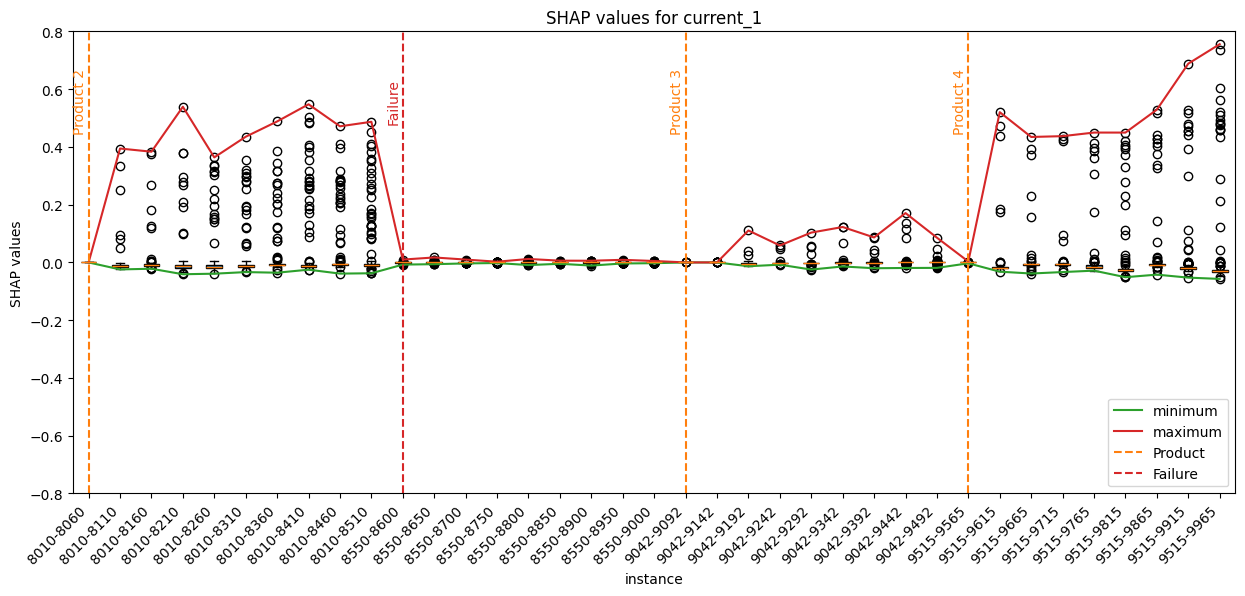

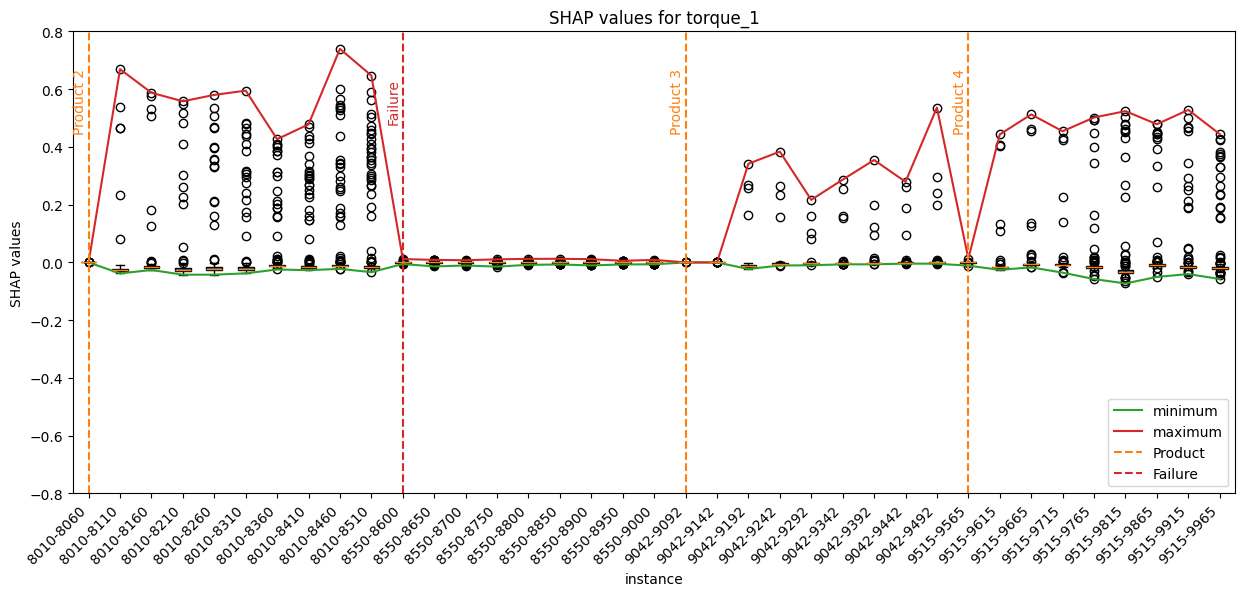

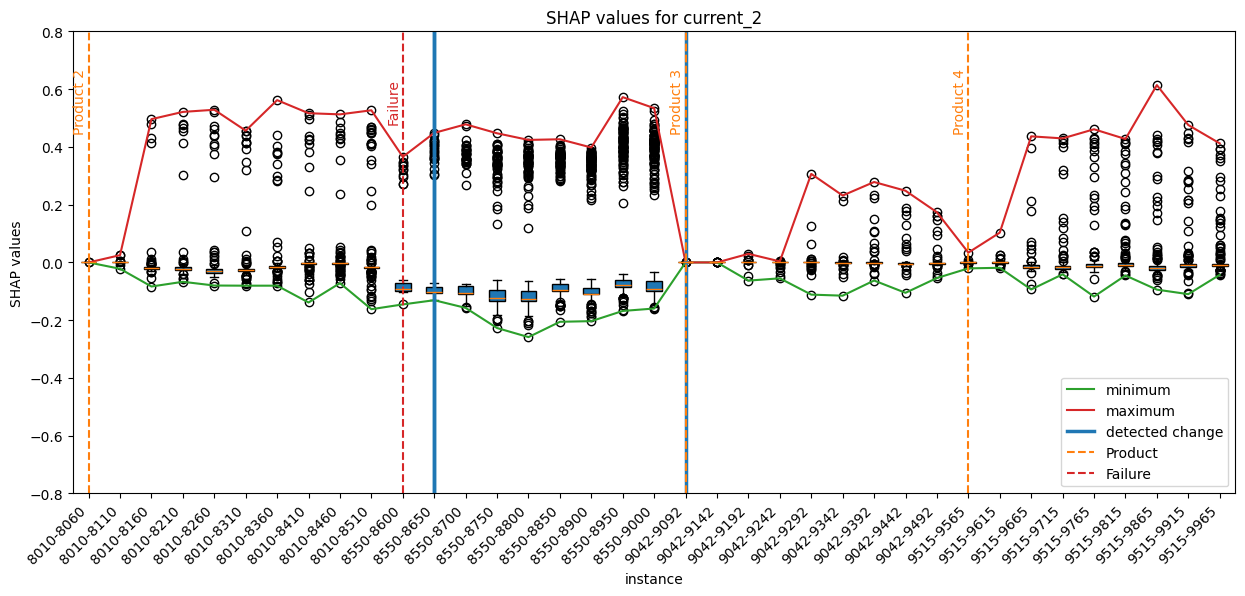

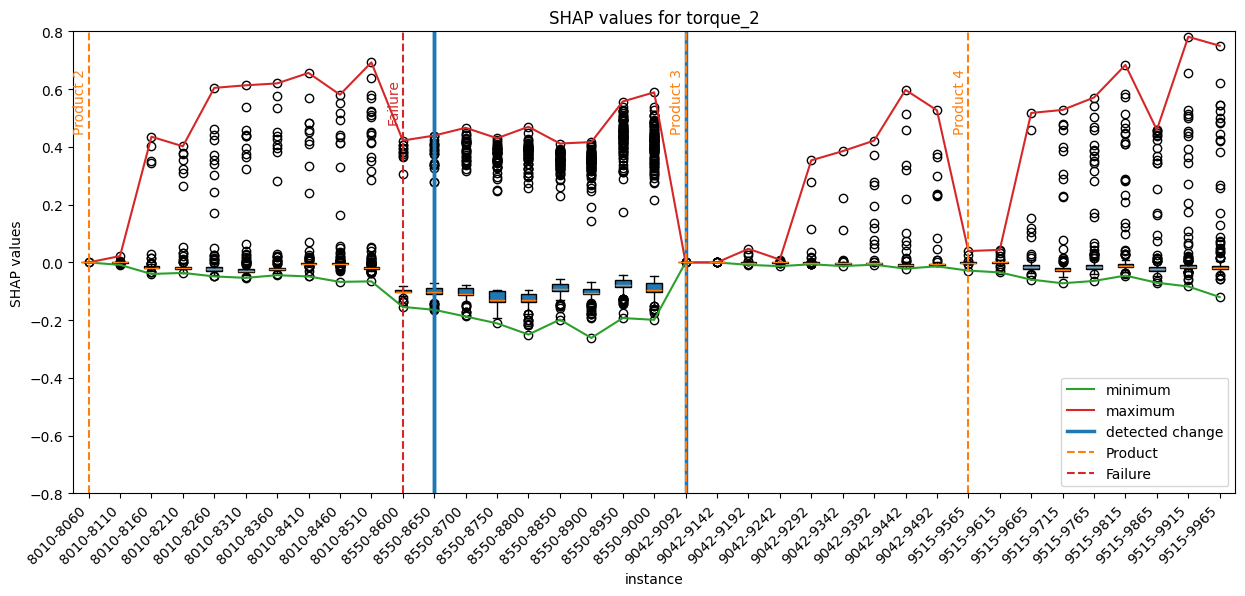

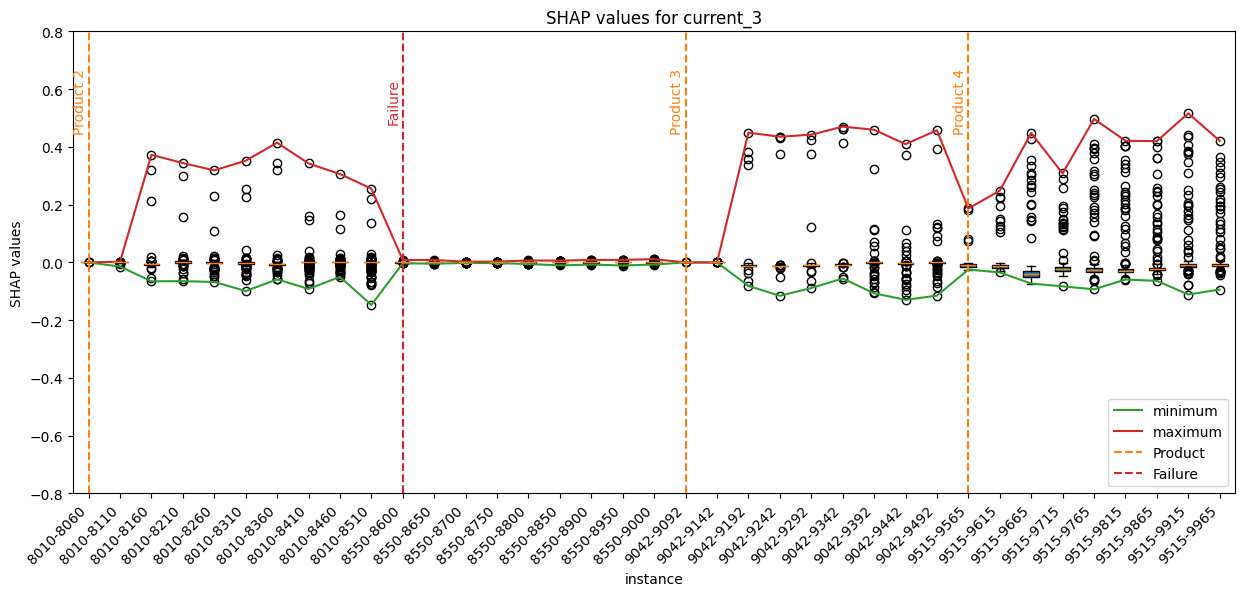

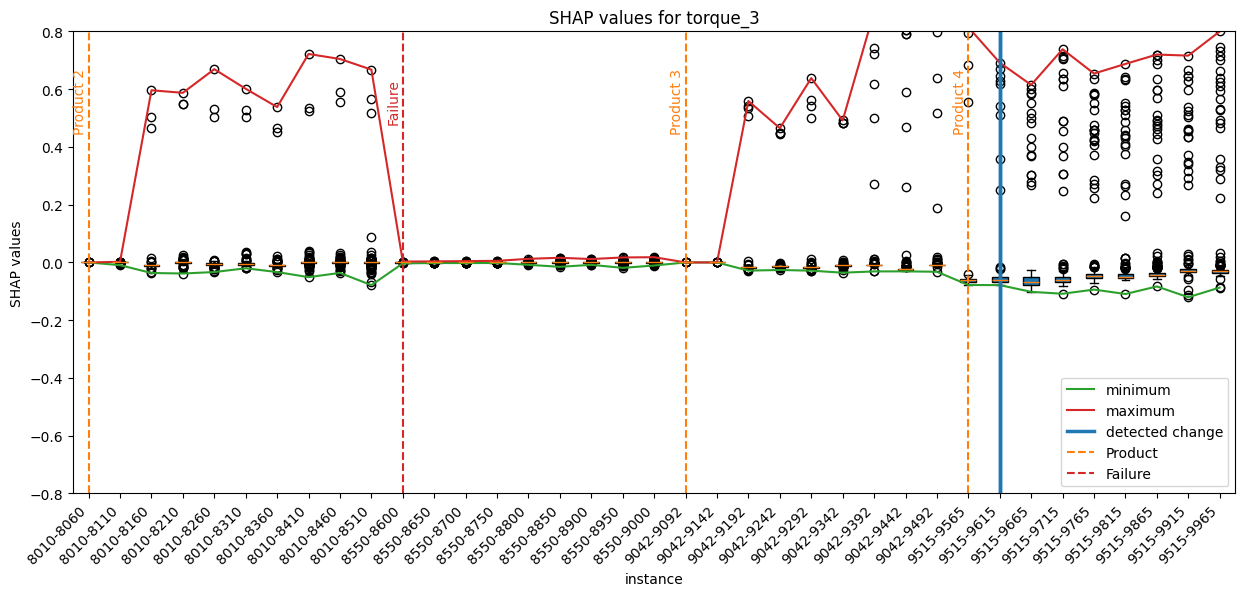

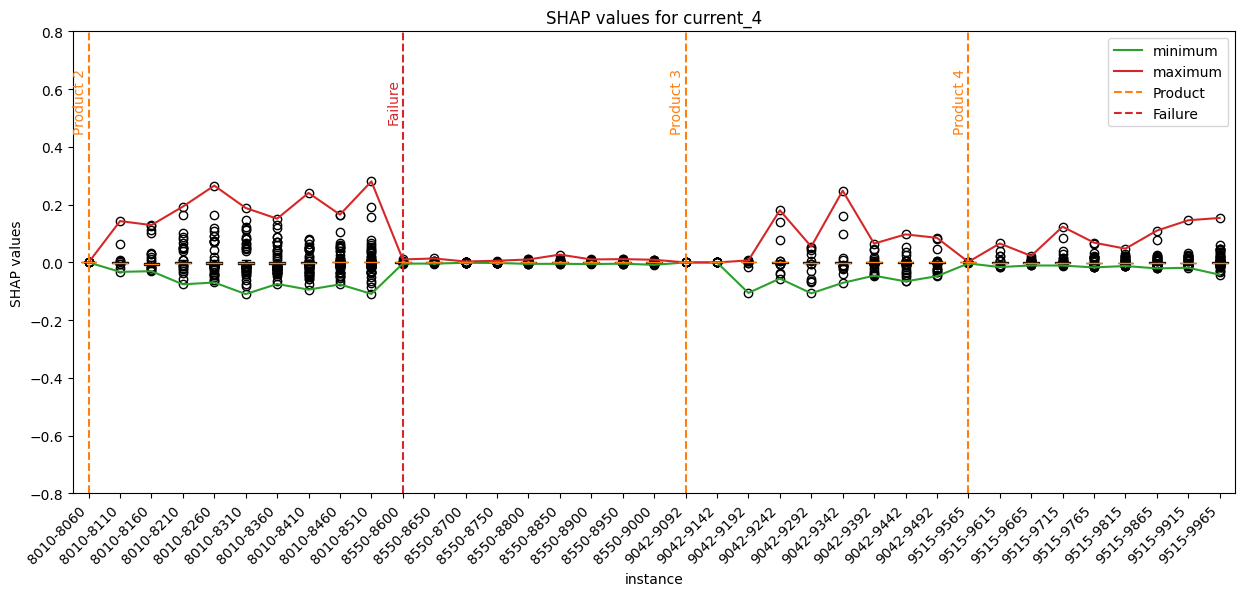

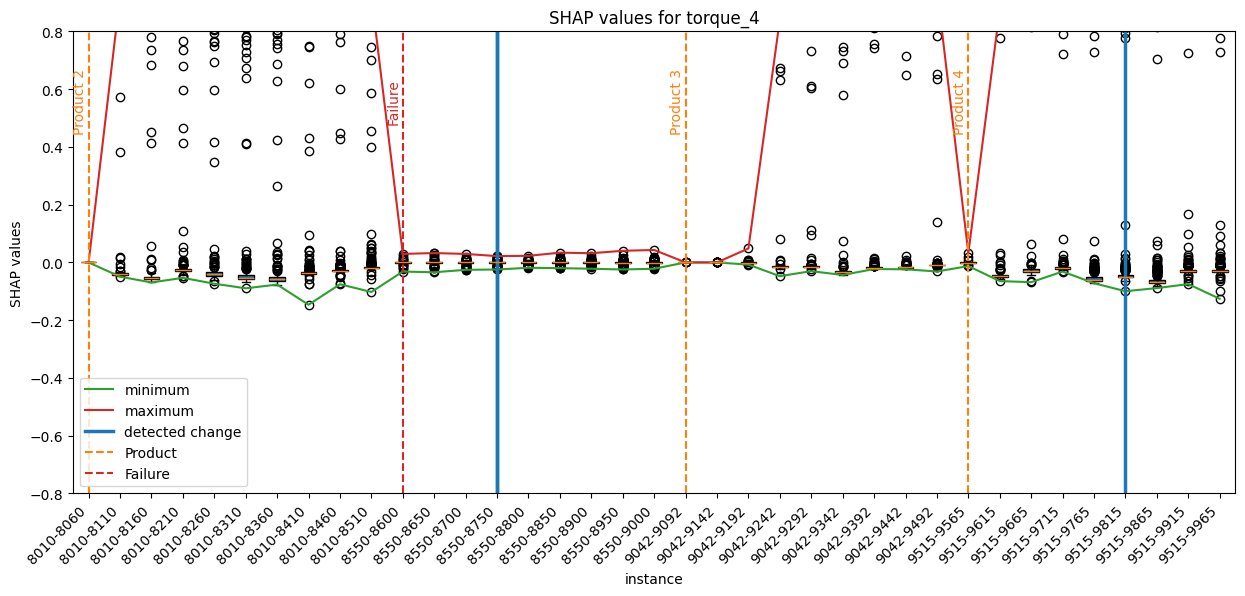

In [27]:

result_info = pd.read_csv(f"{filepath}/result_info.csv", index_col = [0])
min_instances=0
delta=0.01
threshold=0.08
alpha=0.9999
y_min = -0.8
y_max = 0.8
cols_2 = ["current_2", "torque_2"]
cols_important = ["current_1", "torque_1", "current_2", "torque_2", "current_3", "torque_3", "current_4", "torque_4"]
for col in cols_important:
    
    cols_for_xai = [col]
    window = batch_size =50

    all_medians = []
    xticks_labels = []
    minimum = []
    maximum = []
    median = []

    ph = PageHinkley(min_instances=min_instances, delta=delta, threshold=threshold, alpha=alpha)
    stream_changes=[]

    
    for i in range(1, len(result_info)+1):
        
        #df_grouped = df_shap_batches.groupby(level=0).mean().reset_index(drop=True)
        nr_changes = len(result_info)
        xticks = list(range(1,nr_changes+1))

        
        #for i in range(nr_changes):
            #start_index = i * window + 8000
            #end_index = (i+1) * window + 8000
            #xticks_labels.append(f"{start_index}-{end_index}")
            
            
        shap_data = pd.read_csv(f"{filepath}/sv_batch_{i-1}.csv", index_col = [0], names=x_cols, header=0)
    
        start_index = shap_data.index[0]
        end_index = shap_data.index[-1] + 1
        xticks_labels.append(f"{start_index}-{end_index}")
            
        shap_data = shap_data[cols_for_xai].values.flatten()      
        maximum.append(np.max(shap_data))
        minimum.append(np.min(shap_data))
        median.append(np.median(shap_data))
        ph.update(np.median(shap_data))
        if ph.drift_detected:
            stream_changes.append(i)

        all_medians.append(shap_data)
        
        
        
        
    plt.figure(figsize=(15,6))
    plt.boxplot(all_medians,
                                vert=True,  # vertical box alignment
                                 patch_artist=True) 
    plt.plot(list(range(1, nr_changes+1)), minimum, label = "minimum", color="tab:green")
    plt.plot(list(range(1, nr_changes+1)), maximum, label = "maximum", color="tab:red")
 
            #plt.plot(list(range(1, nr_changes+1)), median, label = "median", color="tab:orange")
    plt.xticks(xticks, xticks_labels, rotation=45, ha='right')
    if len(stream_changes)>0:
        plt.axvline(x=stream_changes[0], color='tab:blue', linewidth=2.5, label="detected change", linestyle="-")
        for change in stream_changes:
            plt.axvline(x=change, color='tab:blue', linewidth=2.5, linestyle="-")

    plt.axvline(x=xticks[len(xticks)//2+1], color='tab:orange', linewidth=1.5, label="Product", linestyle="--")
    plt.text(xticks[len(xticks)//2+1]-0.5, 0.7*y_max, 'Product 3', rotation=90, verticalalignment='center', color="tab:orange")
    
    plt.axvline(x=xticks[len(xticks)*3//4+1], color='tab:orange', linewidth=1.5, linestyle="--")
    plt.text(xticks[len(xticks)*3//4+1]-0.5, 0.7*y_max, 'Product 4', rotation=90, verticalalignment='center', color="tab:orange")
    
    plt.axvline(x=xticks[len(xticks)//4+1], color='tab:red', linewidth=1.5, label="Failure", linestyle="--")
    plt.text(xticks[len(xticks)//4+1]-0.5, 0.7*y_max, 'Failure', rotation=90, verticalalignment='center', color="tab:red")
    
    plt.axvline(x=xticks[0], color='tab:orange', linewidth=1.5, linestyle="--")
    plt.text(xticks[0]-0.5, 0.7*y_max, 'Product 2', rotation=90, verticalalignment='center', color="tab:orange")
    plt.ylim([y_min, y_max])
    plt.legend(loc="best")
    plt.xlabel("instance")
    plt.ylabel("SHAP values")
    plt.title(f"SHAP values for {cols_for_xai[0]}")
    #plt.savefig(f'ECAI code/figures/Boxplot_batch_50_{cols_for_xai[0]}.pdf', format='pdf',bbox_inches='tight')
    plt.show()

In [28]:
x_cols = ['work_roll_diam_1',
       'work_roll_diam_2', 'work_roll_diam_3', 'work_roll_diam_4',
       'work_roll_mileage_1', 'work_roll_mileage_2', 'work_roll_mileage_3',
       'work_roll_mileage_4', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'tension_1', 'tension_2', 'tension_3', 'tension_4',
       'tension_5', 'roll_speed_1', 'roll_speed_2', 'roll_speed_3',
       'roll_speed_4', 'force_1', 'force_2', 'force_3', 'force_4', 'torque_1',
       'torque_2', 'torque_3', 'torque_4', 'gap_1', 'gap_2', 'gap_3', 'gap_4',
       'current_1', 'current_2', 'current_3', 'current_4']

In [29]:

def get_encoder(input_shape=(X[x_cols].shape[1],)):
    model = Sequential()
    model.add(Dense(100, activation='relu',
                    input_shape=input_shape))
    model.add(Dense(10, activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(2, activation="sigmoid"))
    #model.add(Dense(X[x_cols].shape[1], activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.00001), loss=BinaryFocalLoss(gamma=10))
    return model

def get_task(input_shape=(X[x_cols].shape[1],)):
    model = Sequential()
    model.add(Dense(10, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.00001), loss=BinaryFocalLoss(gamma=10))
    return model

def get_discriminator(input_shape=(X[x_cols].shape[1],)):
    model = Sequential()
    model.add(Dense(10, activation='relu'))
    #model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryFocalLoss(gamma=2))
    return model



def get_source(input_shape=(X[x_cols].shape[1],)):
    model = Sequential()
    model.add(Dense(100, activation='relu',
                    input_shape=input_shape))
    model.add(Dense(10, activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(2, activation="sigmoid"))
    
    model.add(Dense(10, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(1, activation="sigmoid"))

    #model.add(Dense(X[x_cols].shape[1], activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.00001), loss=BinaryFocalLoss(gamma=10))
    return model



ccsa_enc = get_encoder()
ccsa_disc= get_discriminator()
ccsa_task = get_task()

In [30]:
X = X[x_cols + ["class"]]
split_X = split_dataframes_based_on_drift(X, stream_change)

In [31]:
split_X[0]["class"].value_counts()

class
0    7330
1     680
Name: count, dtype: int64

In [32]:
split_X[1]["class"].value_counts()

class
0    447
1     93
Name: count, dtype: int64

In [33]:
split_X[2]["class"].value_counts()

class
1    350
0    142
Name: count, dtype: int64

In [34]:
split_X[3]["class"].value_counts()

class
0    445
1     28
Name: count, dtype: int64

In [35]:
split_X[4]["class"].value_counts()

class
0    422
1     63
Name: count, dtype: int64

In [36]:
y_col = "class"
data_source = split_X[0]
Xs = data_source[x_cols]
ys = data_source[y_col].values

data_target_1 = split_X[1] #product data
Xt_1 = data_target_1[x_cols]
yt_1 = data_target_1[y_col].values

data_target_2 = split_X[2] #failure data
Xt_2 = data_target_2[x_cols]
yt_2 = data_target_2[y_col].map(lambda x: 1 if x==0 else 0).values


data_target_3 = split_X[3] #product data
Xt_3 = data_target_3[x_cols]
yt_3 = data_target_3[y_col].values


data_target_4 = split_X[4] #product data
Xt_4 = data_target_4[x_cols]
yt_4 = data_target_4[y_col].values

In [37]:
INIT_LR = 0.001 
alpha = 0.25
gamma = 1
BATCH_SIZE = 128
EPOCHS = 500

decay=INIT_LR / EPOCHS

decay=INIT_LR / EPOCHS
model_1 = CCSA(ccsa_enc, ccsa_task, Xt=Xt_1, yt=yt_1, metrics=["acc"], 
               loss=BinaryFocalCrossentropy(gamma=gamma,  apply_class_balancing=True, alpha=alpha), 
               random_state=0, optimizer=Adam(learning_rate=INIT_LR, clipvalue=0.5)) #model initialization
model_1.compile()
model_1.fit(X=Xs, y=ys, Xt=Xt_1, yt=yt_1, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)


model_2 = CCSA(ccsa_enc, ccsa_task, Xt=Xt_2, yt=yt_2, metrics=["acc"], 
               loss=BinaryFocalCrossentropy(gamma=gamma,  apply_class_balancing=True, alpha=alpha), 
               random_state=0, optimizer=Adam(learning_rate=INIT_LR, clipvalue=0.5)) #model initialization
model_2.compile()
model_2.fit(X=Xs, y=ys, Xt=Xt_2, yt=yt_2, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)



model_3 = CCSA(ccsa_enc, ccsa_task, Xt=Xt_3, yt=yt_3, metrics=["acc"], 
               loss=BinaryFocalCrossentropy(gamma=gamma,  apply_class_balancing=True, alpha=alpha), 
               random_state=0, optimizer=Adam(learning_rate=INIT_LR, clipvalue=0.5)) #model initialization
model_3.compile()
model_3.fit(X=Xs, y=ys, Xt=Xt_3, yt=yt_3, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)


model_4 = CCSA(ccsa_enc, ccsa_task, Xt=Xt_4, yt=yt_4, metrics=["acc"], 
               loss=BinaryFocalCrossentropy(gamma=gamma,  apply_class_balancing=True, alpha=alpha), 
               random_state=0, optimizer=Adam(learning_rate=INIT_LR, clipvalue=0.5)) #model initialization
model_4.compile()
model_4.fit(X=Xs, y=ys, Xt=Xt_4, yt=yt_4, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

In [38]:
confusion_matrix(yt_1, np.round(model_1.predict(Xt_1)))

array([[447,   0],
       [  0,  93]])

In [39]:
f1_score(yt_1, np.round(model_1.predict(Xt_1)))

1.0

In [40]:
confusion_matrix(yt_2, np.round(model_2.predict(Xt_2)))

array([[350,   0],
       [  0, 142]])

In [41]:
f1_score(yt_2, np.round(model_2.predict(Xt_2)))

1.0

In [42]:
confusion_matrix(yt_3, np.round(model_3.predict(Xt_3)))

array([[445,   0],
       [  0,  28]])

In [43]:
f1_score(yt_3, np.round(model_3.predict(Xt_3)))

1.0

In [44]:
confusion_matrix(yt_4, np.round(model_4.predict(Xt_4)))

array([[422,   0],
       [  0,  63]])

In [45]:
f1_score(yt_4, np.round(model_4.predict(Xt_4)))

1.0

In [46]:
display(confusion_matrix(ys, np.round(model_1.predict(Xs))))
print(f1_score(ys, np.round(model_1.predict(Xs))))

display(confusion_matrix(ys, np.round(model_2.predict(Xs))))
print(f1_score(ys, np.round(model_2.predict(Xs))))

display(confusion_matrix(ys, np.round(model_3.predict(Xs))))
print(f1_score(ys, np.round(model_3.predict(Xs))))

display(confusion_matrix(ys, np.round(model_4.predict(Xs))))
print(f1_score(ys, np.round(model_4.predict(Xs))))

array([[7330,    0],
       [   0,  680]])

1.0


array([[7330,    0],
       [   0,  680]])

1.0


array([[7330,    0],
       [   0,  680]])

1.0


array([[7330,    0],
       [   0,  680]])

1.0


In [47]:
ds_model = get_task()
dt_model = get_task()
dt_model_anomaly = get_task()
ds_model.fit(x=Xs, y=ys,
          epochs=500, batch_size=100, verbose=0)

dt_model.fit(x=Xt_1, y=yt_1,
          epochs=500, batch_size=100, verbose=0)

dt_model_anomaly.fit(x=Xt_2, y=yt_2,
          epochs=500, batch_size=100, verbose=0)

In [48]:
display(confusion_matrix(yt_1, np.round(ds_model.predict(Xt_1))))
print(f1_score(yt_1, np.round(ds_model.predict(Xt_1))))

display(confusion_matrix(yt_2, np.round(ds_model.predict(Xt_2))))
print(f1_score(yt_2, np.round(ds_model.predict(Xt_2))))


display(confusion_matrix(yt_3, np.round(ds_model.predict(Xt_3))))
print(f1_score(yt_3, np.round(ds_model.predict(Xt_3))))

display(confusion_matrix(yt_4, np.round(ds_model.predict(Xt_4))))
print(f1_score(yt_4, np.round(ds_model.predict(Xt_4))))

17/17 [==============================] - 0s 521us/step


array([[188, 259],
       [  0,  93]])

17/17 [==============================] - 0s 522us/step
0.4179775280898877
16/16 [==============================] - 0s 559us/step


array([[  1, 349],
       [104,  38]])

16/16 [==============================] - 0s 514us/step
0.14366729678638943
15/15 [==============================] - 0s 474us/step


array([[331, 114],
       [  0,  28]])

15/15 [==============================] - 0s 483us/step
0.32941176470588235
16/16 [==============================] - 0s 477us/step


array([[ 68, 354],
       [  0,  63]])

16/16 [==============================] - 0s 506us/step
0.2625


In [49]:
feature_names = x_cols
order = feature_names
col2num = {col: i for i, col in enumerate(X.columns)}
order = list(map(col2num.get, order))

In [50]:
display(confusion_matrix(ys, np.round(model_1.predict(Xs))))
print(f1_score(ys, np.round(model_1.predict(Xs))))

display(confusion_matrix(ys, np.round(model_2.predict(Xs))))
print(f1_score(ys, np.round(model_2.predict(Xs))))

array([[7330,    0],
       [   0,  680]])

1.0


array([[7330,    0],
       [   0,  680]])

1.0


In [51]:
display(confusion_matrix(yt_1, np.round(model_1.predict(Xt_1))))
print(f1_score(yt_1, np.round(model_1.predict(Xt_1))))

display(confusion_matrix(yt_2, np.round(model_2.predict(Xt_2))))
print(f1_score(yt_2, np.round(model_2.predict(Xt_2))))

array([[447,   0],
       [  0,  93]])

1.0


array([[350,   0],
       [  0, 142]])

1.0


In [52]:

data_target_2 = split_X[2] #failure data
Xt_2 = data_target_2[x_cols]
#yt_2 = data_target_2[y_col].map(lambda x: 1 if x==0 else 0).values
yt_2 = data_target_2[y_col]

In [53]:
ex1,sv1=getshap_barplot(Xt_1.values, x_cols, ds_model)
ex2,sv2=getshap_barplot(Xt_1.values, x_cols, model_1)

PermutationExplainer explainer: 541it [00:11,  9.66it/s]                         
PermutationExplainer explainer: 541it [00:19, 13.62it/s]                         


In [54]:
y_pred_source_comb = np.round(ds_model.predict(Xt_1)).ravel()
y_pred_adapted_comb = np.round(model_1.predict(Xt_1)).ravel()
Xcomb_source_anomaly = Xt_1[y_pred_source_comb==1]
Xcomb_adapted_anomaly = Xt_1[y_pred_adapted_comb==1]
Xcomb_adapted_normal = Xt_1[y_pred_adapted_comb==0]

17/17 [==============================] - 0s 598us/step


In [55]:
#sv1_anomaly = ex1(Xcomb_source_anomaly)
sv2_anomaly = ex2(Xcomb_adapted_anomaly)
sv2_normal = ex2(Xcomb_adapted_normal)

PermutationExplainer explainer: 448it [00:15, 10.34it/s]                         


In [56]:
ex12,sv12=getshap_barplot(Xt_2.values, x_cols, ds_model)
ex22,sv22=getshap_barplot(Xt_2.values, x_cols, model_2)

PermutationExplainer explainer: 493it [00:17, 12.15it/s]                         


In [57]:
y_pred_source_comb1 = np.round(ds_model.predict(Xt_2)).ravel()
y_pred_adapted_comb1 = np.round(model_2.predict(Xt_2)).ravel()
Xcomb1_source_anomaly = Xt_2[y_pred_source_comb1==1]
Xcomb1_adapted_anomaly = Xt_2[y_pred_adapted_comb1==1]
Xcomb1_adapted_normal = Xt_2[y_pred_adapted_comb1==0]

16/16 [==============================] - 0s 561us/step


In [58]:
#sv12_anomaly = ex12(Xcomb1_source_anomaly)
sv22_anomaly = ex22(Xcomb1_adapted_anomaly)
sv22_normal = ex22(Xcomb1_adapted_normal)

PermutationExplainer explainer: 351it [00:12,  4.98it/s]                         


In [59]:
ex13,sv13=getshap_barplot(Xt_3.values, x_cols, ds_model)
ex23,sv23=getshap_barplot(Xt_3.values, x_cols, model_3)

PermutationExplainer explainer: 474it [00:16, 11.27it/s]                         


In [60]:
ex14,sv14=getshap_barplot(Xt_4.values, x_cols, ds_model)
ex24,sv24=getshap_barplot(Xt_4.values, x_cols, model_4)

PermutationExplainer explainer: 486it [00:16, 11.74it/s]                         


In [61]:
median_source_product = np.median(sv1.values, axis=0)
median_adapted_product = np.median(sv2.values, axis=0)
median_source_failure = np.median(sv12.values, axis=0)
median_adapted_failure = np.median(sv22.values, axis=0)
median_source_product_1= np.median(sv13.values, axis=0)
median_adapted_product_1 = np.median(sv23.values, axis=0)
median_source_product_2= np.median(sv14.values, axis=0)
median_adapted_product_2 = np.median(sv24.values, axis=0)

In [62]:
df_median_adapted_product_1 = pd.DataFrame(median_adapted_product.reshape(1,-1), columns=x_cols)
df_median_adapted_failure = pd.DataFrame(median_adapted_failure.reshape(1,-1), columns=x_cols)
df_median_adapted_product_2 = pd.DataFrame(median_adapted_product_1.reshape(1,-1), columns=x_cols)
df_median_adapted_product_3 = pd.DataFrame(median_adapted_product_2.reshape(1,-1), columns=x_cols)

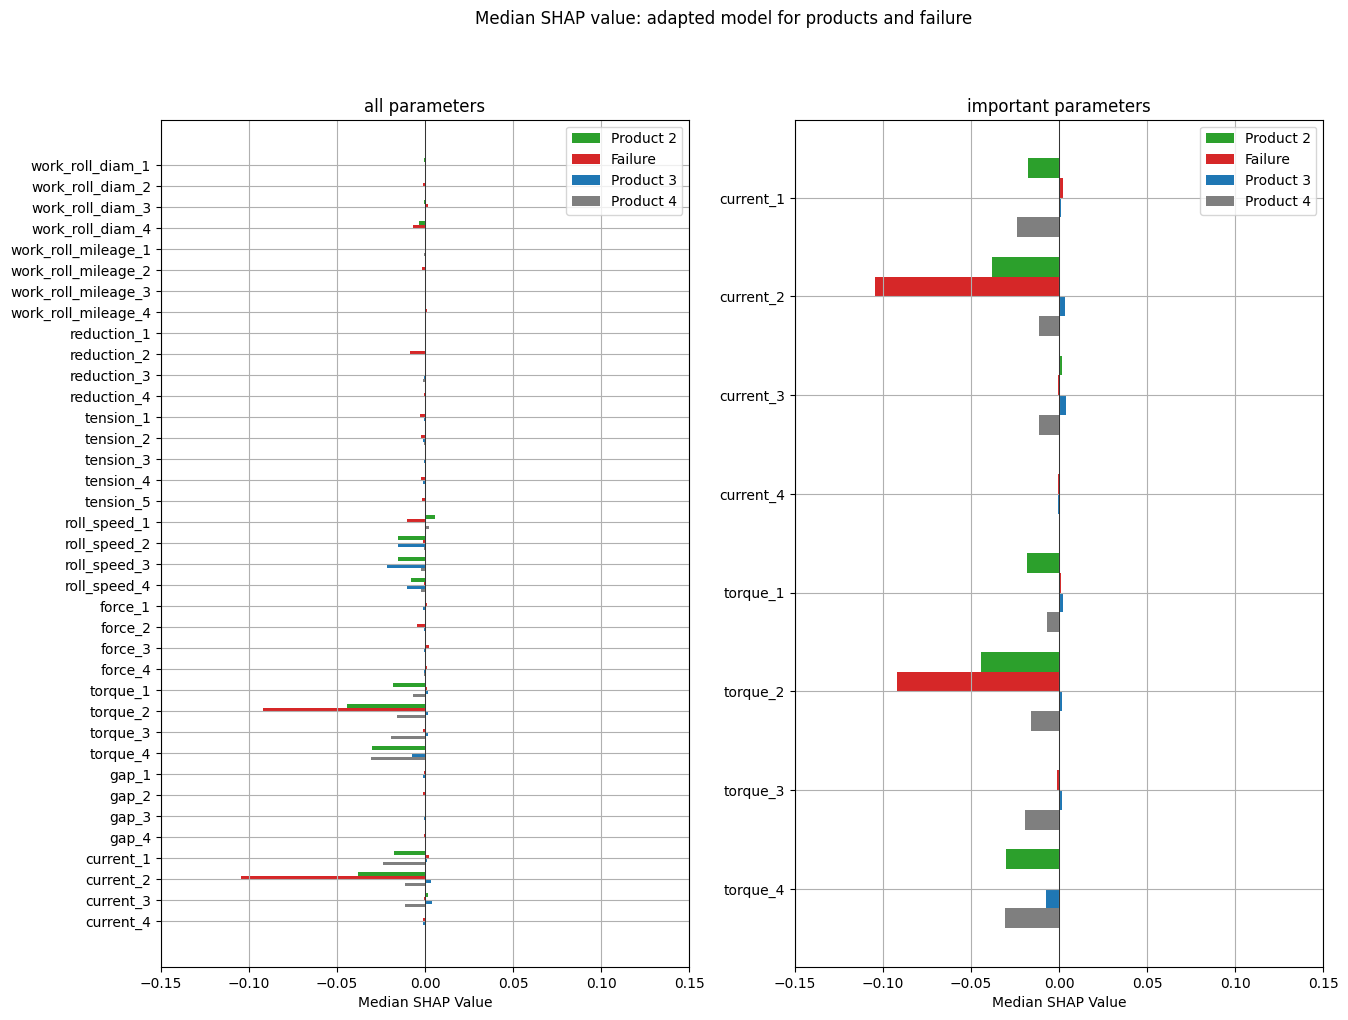

In [63]:
interest_cols = ["current_1", "current_2", "current_3", "current_4",
                "torque_1", "torque_2", "torque_3", "torque_4"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 11))

xticks = np.array(range(0, 3*len(x_cols), 3))
width = 0.5
ax1.barh(xticks, median_adapted_product, width, align='center', label="Product 2", color="tab:green")
ax1.barh(xticks+width, median_adapted_failure, width, align='center', label="Failure", color ="tab:red" )
ax1.barh(xticks+2*width, median_adapted_product_1, width, align='center', label="Product 3", color ="tab:blue" )
ax1.barh(xticks+3*width, median_adapted_product_2, width, align='center', label="Product 4", color ="tab:grey" )
ax1.axvline(x=0, color='black', linewidth=0.5)
#ax.set_yticks(xticks, labels=x_cols)
ax1.set(yticks=xticks + 1.5*width, yticklabels=x_cols)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_xlabel('Median SHAP Value')
ax1.set_title('all parameters')
ax1.legend(loc="best")
ax1.grid(True)
ax1.set_xlim([-0.15, 0.15])

xticks = np.array(range(0, 2*len(interest_cols), 2))
width = 0.4
ax2.barh(xticks, df_median_adapted_product_1[interest_cols].values[0], width, align='center', label="Product 2", color="tab:green")
ax2.barh(xticks+width, df_median_adapted_failure[interest_cols].values[0], width, align='center', label="Failure", color ="tab:red" )
ax2.barh(xticks+2*width, df_median_adapted_product_2[interest_cols].values[0], width, align='center', label="Product 3", color ="tab:blue" )
ax2.barh(xticks+3*width, df_median_adapted_product_3[interest_cols].values[0], width, align='center', label="Product 4", color ="tab:grey" )
ax2.axvline(x=0, color='black', linewidth=0.5)
#ax.set_yticks(xticks, labels=x_cols)
ax2.set(yticks=xticks + 1.5*width, yticklabels=interest_cols)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_xlabel('Median SHAP Value')
ax2.set_title('important parameters')
ax2.legend(loc="best")
ax2.grid(True)
ax2.set_xlim([-0.15, 0.15])
#plt.grid()
plt.suptitle("Median SHAP value: adapted model for products and failure")
#plt.savefig(f'ECAI code/figures/median_2_plots.pdf', format='pdf',bbox_inches='tight')
plt.show()

In [64]:
from sklearn.neighbors import LocalOutlierFactor
def plot_outliers_in_signals_LOF(df: pd.DataFrame,
                  cols = ["torque", "current", "force"],
                  stand = 1,
                 changes = [8000,8500, 9002, 9501]):
    
    for col in cols:
        y_lim = (180000 if col == "torque" else 
         (8000 if col == "current" else 
          1.5 * 10**7))
        x_col = col+f"_{stand}"
        source_change = changes[0]

        lof = LocalOutlierFactor(novelty=True)
        lof = LocalOutlierFactor(algorithm =  'auto', leaf_size = 10, n_neighbors = 20, p= 1, novelty=True)
        X_train = df[x_col][:source_change].values
        y_train = df[["class"]][:source_change].map(lambda x: -1 if x==1 else 1)
        X_test = df[x_col][source_change:].values
        y_test = df["class"][source_change:].values

        X_train_svm = df[:source_change]
        X_train_svm = X_train_svm[X_train_svm["class"]==0]
        X_train_svm = X_train_svm[x_col].values
        
        
        X_test = df[x_col][source_change:].values
        y_test = df["class"][source_change:].values

        print(f"training : {x_col}")
    
        lof.fit(X_train_svm.reshape(-1,1))
        

        lof_pred_train = lof.predict(X_train.reshape(-1,1))
        lof_pred_test = lof.predict(X_test.reshape(-1,1))
        prediction = pd.DataFrame(np.concatenate([lof_pred_train, lof_pred_test]), columns=["pred"])
 
        
        prediction = pd.DataFrame(lof_pred_test, columns=["pred"], index=df[x_col][source_change:].index)

        plt.figure(figsize=(20,8))
        plt.scatter(df.index, df[x_col], s=5)
        plt.axvline(x=prediction[prediction["pred"]==-1].index[0], color="darkgrey", zorder=0, linestyle='-', linewidth=0.2, label="Anomaly")
        for idx in prediction[prediction["pred"]==-1].index:
            plt.axvline(x=idx, color="darkgrey", zorder=0, linestyle='-', linewidth=0.2)

        plt.axvline(x=changes[1], color='tab:red', linestyle='--', label="Failure")
        plt.text(changes[1]-100, 0.9*y_lim, 'Failure', rotation=90, verticalalignment='center', color="tab:red")
        
        plt.axvline(x=changes[0], color='tab:orange', linestyle='--')
        plt.text(changes[0]-100, 0.9*y_lim, 'Product 2', rotation=90, verticalalignment='center', color="tab:orange")
        
        plt.axvline(x=changes[2], color='tab:orange', linestyle='--')
        plt.text(changes[2]-100, 0.9*y_lim, 'Product 3', rotation=90, verticalalignment='center', color="tab:orange")
        
        plt.axvline(x=changes[3], color='tab:orange', linestyle='--')
        plt.text(changes[3]-100, 0.9*y_lim, 'Product 4', rotation=90, verticalalignment='center', color="tab:orange")
        
        plt.axvline(x=0, color='tab:orange', linestyle='--', label="Product")
        plt.text(0-100, 0.9*y_lim, 'Product 1', rotation=90, verticalalignment='center', color="tab:orange")
    
        plt.title(f"LOF results for {x_col}")
        plt.xlabel("instance")
        plt.ylabel(x_col)
        plt.legend(loc="best")
        plt.ylim([0,y_lim])
        #plt.grid()
        #plt.savefig(f'ECAI figures/LOF_{x_col}.pdf', format='pdf',bbox_inches='tight')
        plt.show()

training : torque_2


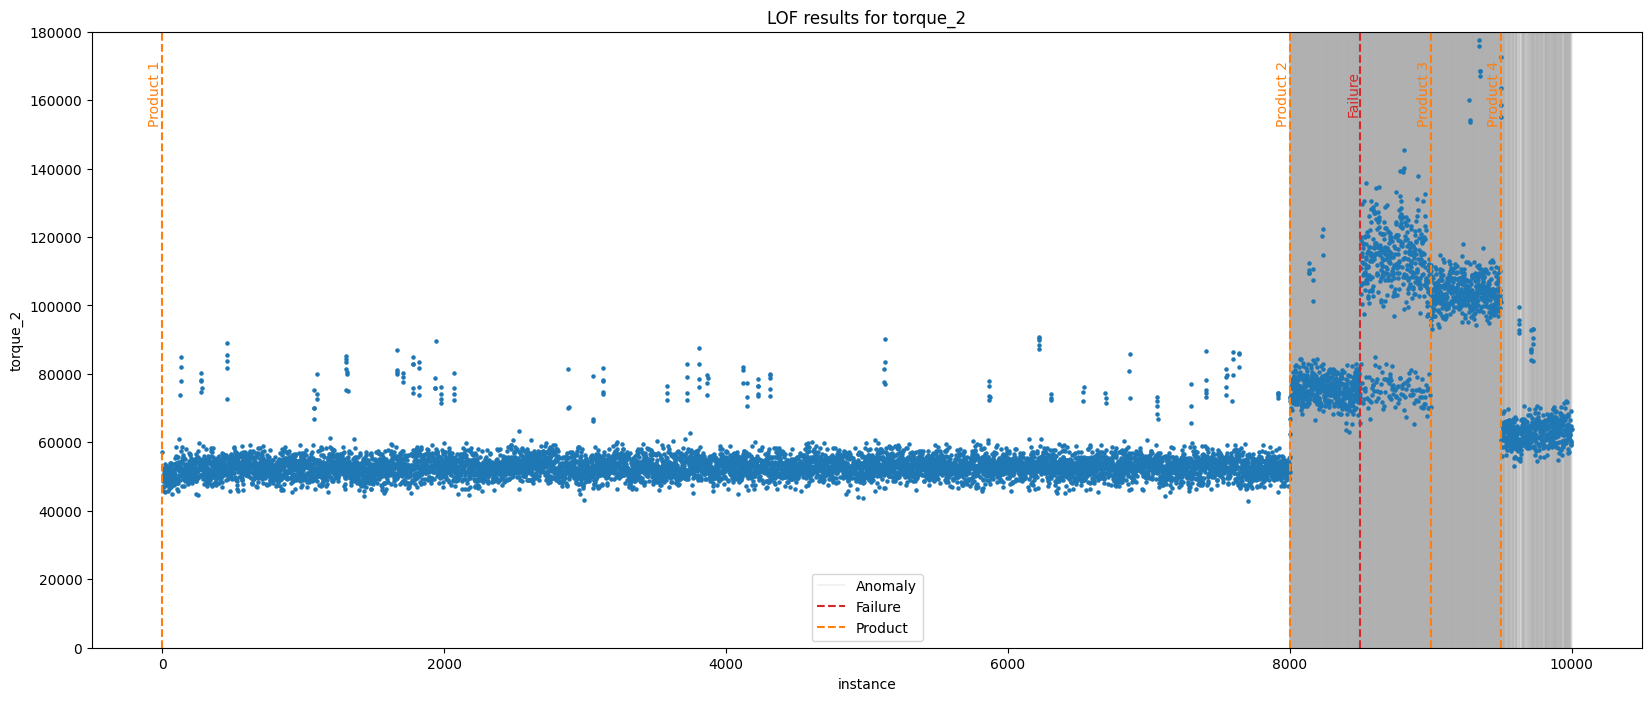

training : current_2


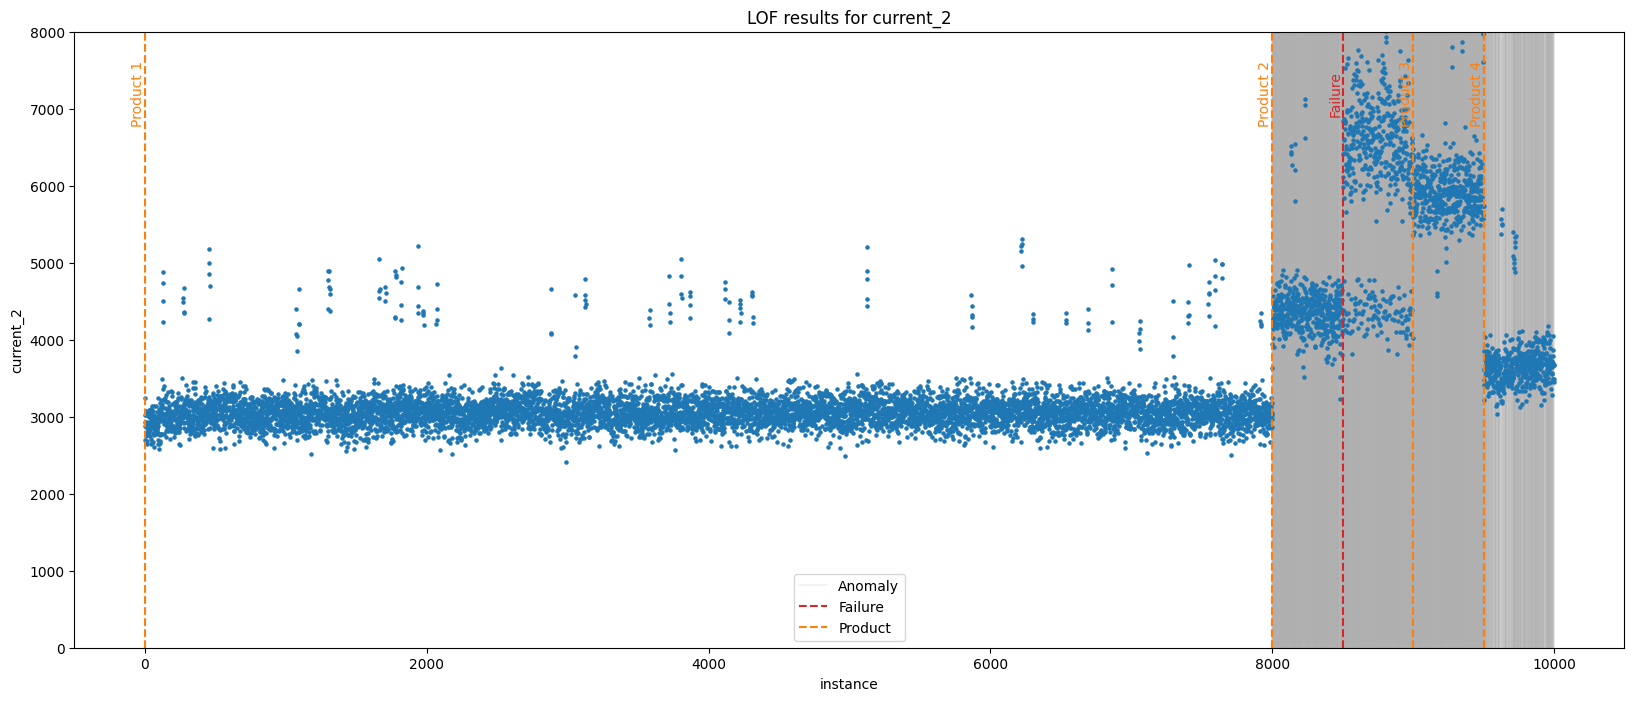

In [65]:
plot_outliers_in_signals_LOF(df = df,
                  cols = ["torque", "current"],
                  stand = 2,
                 changes = [8000,8500, 9000, 9500])

In [66]:
from sklearn.ensemble import IsolationForest
def plot_outliers_in_signals_IF(df: pd.DataFrame,
                  cols = ["torque", "current", "force"],
                  stand = 1,
                 changes = [8000,8500, 9000, 9500]):
    
    for col in cols:
        y_lim = (180000 if col == "torque" else 
         (8000 if col == "current" else 
          1.5 * 10**7))
        x_col = col+f"_{stand}"
        source_change = changes[0]

        lof = IsolationForest()
        X_train = df[x_col][:source_change].values
        y_train = df[["class"]][:source_change].map(lambda x: -1 if x==1 else 1)

        X_train_svm = df[:source_change]
        X_train_svm = X_train_svm[X_train_svm["class"]==0]
        X_train_svm = X_train_svm[x_col].values
        
      
       
        print(f"training : {x_col}")
   
        lof.fit(X_train_svm.reshape(-1,1))
        
        X_test = df[x_col][source_change:].values
        y_test = df["class"][source_change:].values

        lof_pred_train = lof.predict(X_train.reshape(-1,1))
        lof_pred_test = lof.predict(X_test.reshape(-1,1))
        prediction = pd.DataFrame(np.concatenate([lof_pred_train, lof_pred_test]), columns=["pred"])
        
      
        prediction = pd.DataFrame(lof_pred_test, columns=["pred"], index=df[x_col][source_change:].index)
        plt.figure(figsize=(20,8))
        plt.scatter(df.index, df[x_col], s=5)
        plt.axvline(x=prediction[prediction["pred"]==-1].index[0], color="darkgrey", zorder=0, linestyle='-', linewidth=0.2, label="Anomaly")
        for idx in prediction[prediction["pred"]==-1].index:
            plt.axvline(x=idx, color="darkgrey", zorder=0,linestyle='-', linewidth=0.2)

        plt.axvline(x=changes[1], color='tab:red', linestyle='--', label="Failure")
        plt.text(changes[1]-100, 0.9*y_lim, 'Failure', rotation=90, verticalalignment='center', color="tab:red")
        
        plt.axvline(x=changes[0], color='tab:orange', linestyle='--')
        plt.text(changes[0]-100, 0.9*y_lim, 'Product 2', rotation=90, verticalalignment='center', color="tab:orange")
        
        plt.axvline(x=changes[2], color='tab:orange', linestyle='--')
        plt.text(changes[2]-100, 0.9*y_lim, 'Product 3', rotation=90, verticalalignment='center', color="tab:orange")
        
        plt.axvline(x=changes[3], color='tab:orange', linestyle='--')
        plt.text(changes[3]-100, 0.9*y_lim, 'Product 4', rotation=90, verticalalignment='center', color="tab:orange")
        
        plt.axvline(x=0, color='tab:orange', linestyle='--', label="Product")
        plt.text(0-100, 0.9*y_lim, 'Product 1', rotation=90, verticalalignment='center', color="tab:orange")
    
        plt.title(f"IF results for {x_col}")
        plt.xlabel("instance")
        plt.ylabel(x_col)
        plt.legend(loc="best")
        plt.ylim([0,y_lim])
        #plt.grid()
        #plt.savefig(f'ECAI figures/IF_{x_col}.pdf', format='pdf',bbox_inches='tight')
        plt.show()
        

training : torque_2


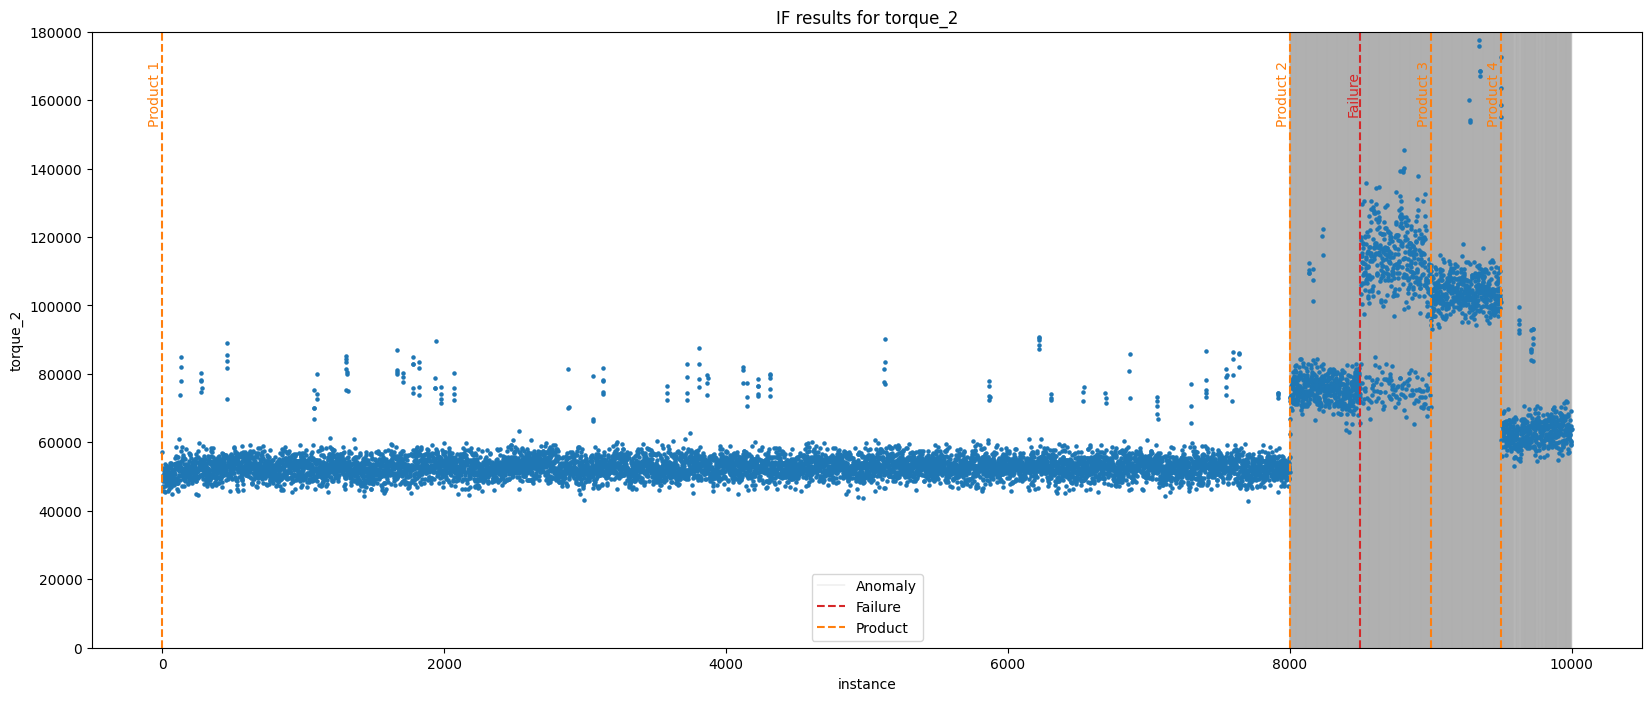

training : current_2


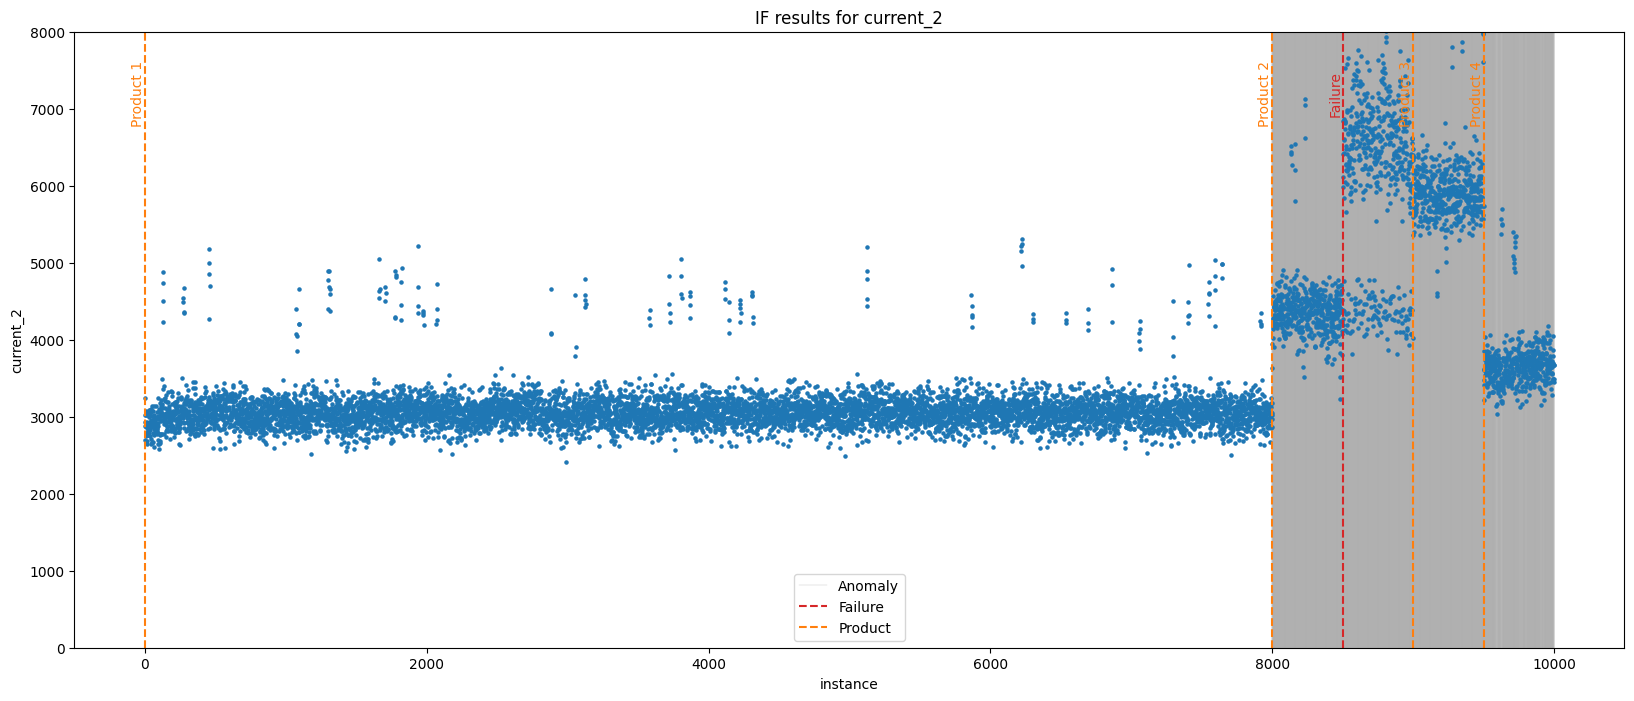

In [67]:
plot_outliers_in_signals_IF(df = df,
                  cols = ["torque", "current"],
                  stand = 2,
                 changes = [8000,8500, 9000, 9500])

In [68]:
from sklearn.svm import OneClassSVM

def plot_outliers_in_signals_SVM(df: pd.DataFrame,
                  cols = ["torque", "current", "force"],
                  stand = 1,
                 changes = [8000,8500, 9000, 9500]):
    
    for col in cols:
        y_lim = (180000 if col == "torque" else 
         (8000 if col == "current" else 
          1.5 * 10**7))
        x_col = col+f"_{stand}"
        source_change = changes[0]

        lof = OneClassSVM(kernel='rbf', degree=6, gamma='scale', coef0=0.1, tol=0.001, nu=0.003)
        X_train = df[x_col][:source_change].values
        y_train = df[["class"]][:source_change].map(lambda x: -1 if x==1 else 1)
        
        X_train_svm = df[:source_change]
        X_train_svm = X_train_svm[X_train_svm["class"]==0]
        X_train_svm = X_train_svm[x_col].values
        
        
        X_test = df[x_col][source_change:].values
        y_test = df["class"][source_change:].values
     
        
        print(f"training : {x_col}")

        lof.fit(X_train_svm.reshape(-1,1))
        lof_pred_train = lof.predict(X_train.reshape(-1,1))
        lof_pred_test = lof.predict(X_test.reshape(-1,1))
        prediction = pd.DataFrame(np.concatenate([lof_pred_train, lof_pred_test]), columns=["pred"])
 
        prediction = pd.DataFrame(lof_pred_test, columns=["pred"], index=df[x_col][source_change:].index)
        plt.figure(figsize=(20,8))
        plt.scatter(df.index, df[x_col], s=5)
        plt.axvline(x=prediction[prediction["pred"]==-1].index[0], color="darkgrey", zorder=0, linestyle='-', linewidth=0.2, label="Anomaly")
        for idx in prediction[prediction["pred"]==-1].index:
            plt.axvline(x=idx, color="darkgrey", zorder=0, linestyle='-', linewidth=0.2)

        plt.axvline(x=changes[1], color='tab:red', linestyle='--', label="Failure")
        plt.text(changes[1]-100, 0.9*y_lim, 'Failure', rotation=90, verticalalignment='center', color="tab:red")
        
        plt.axvline(x=changes[0], color='tab:orange', linestyle='--')
        plt.text(changes[0]-100, 0.9*y_lim, 'Product 2', rotation=90, verticalalignment='center', color="tab:orange")
        
        plt.axvline(x=changes[2], color='tab:orange', linestyle='--')
        plt.text(changes[2]-100, 0.9*y_lim, 'Product 3', rotation=90, verticalalignment='center', color="tab:orange")
        
        plt.axvline(x=changes[3], color='tab:orange', linestyle='--')
        plt.text(changes[3]-100, 0.9*y_lim, 'Product 4', rotation=90, verticalalignment='center', color="tab:orange")
        
        plt.axvline(x=0, color='tab:orange', linestyle='--', label="Product")
        plt.text(0-100, 0.9*y_lim, 'Product 1', rotation=90, verticalalignment='center', color="tab:orange")
    
        plt.title(f"OCSVM results for {x_col}")
        plt.xlabel("instance")
        plt.ylabel(x_col)
        plt.legend(loc="best")
        plt.ylim([0,y_lim])
        #plt.grid()
        #plt.savefig(f'ECAI figures/OCSVM_{x_col}.pdf', format='pdf',bbox_inches='tight')
        plt.show()

training : torque_2


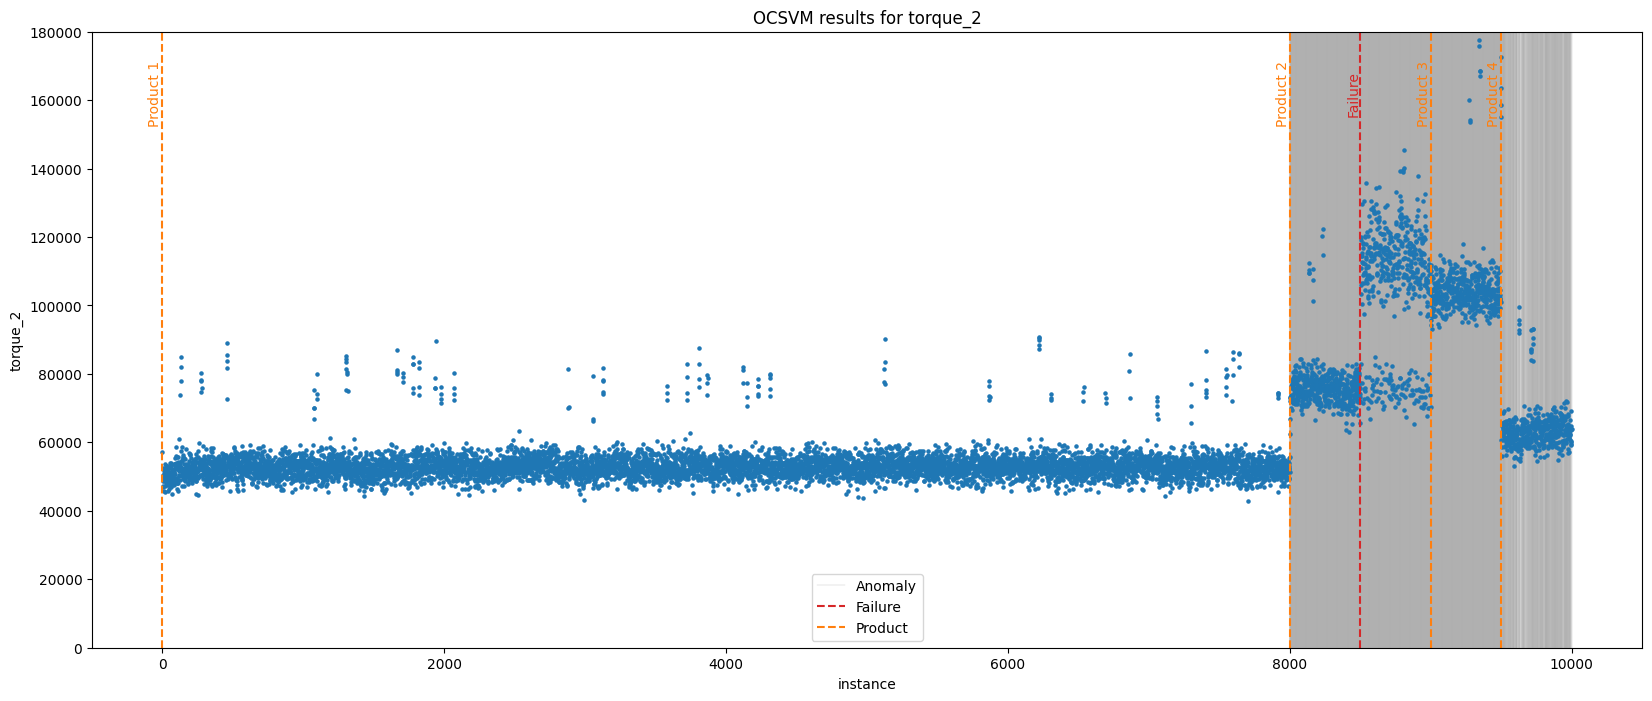

training : current_2


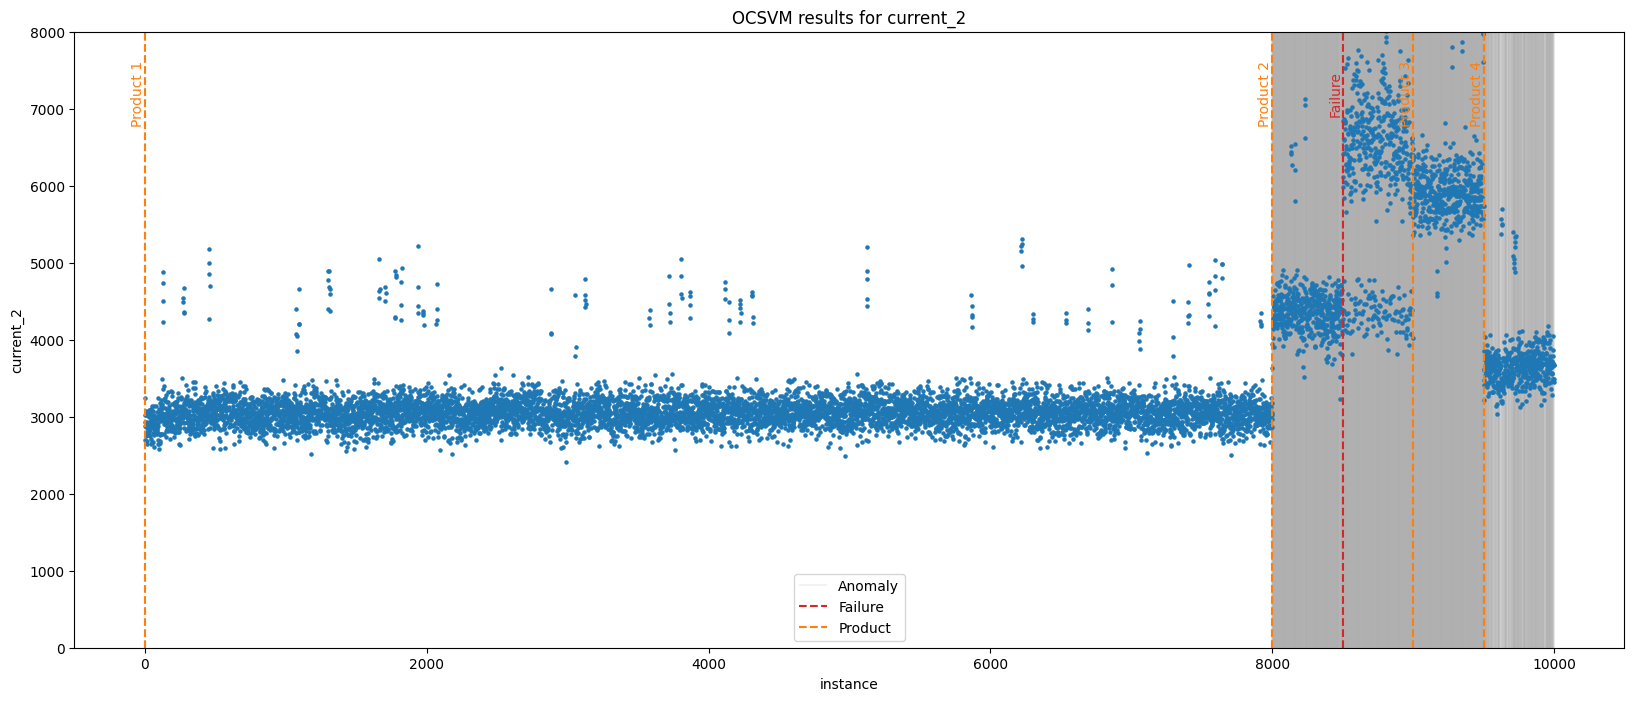

In [69]:
plot_outliers_in_signals_SVM(df = df,
                  cols = ["torque", "current"],
                  stand = 2,
                 changes = [8000,8500, 9000, 9500])

In [70]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import numpy as np

changes = [8000,8500, 9000, 9500]
source_change = changes[0]
x_col = "current_2"
X_train = df[[x_col]][:source_change]
y_train = df[["class"]][:source_change].map(lambda x: -1 if x==1 else 1)
X_test = df[[x_col]][source_change:]
y_test = df["class"][source_change:].values

# Definicja modelu autoenkodera
def create_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    
    encoded = Dense(32, activation='relu')(input_layer)
    encoded = Dense(16, activation='relu')(encoded)
    

    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)
    

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse') 
    
    return autoencoder


def train_autoencoder(X_train, epochs=500, batch_size=128):
    input_dim = X_train.shape[1]
    autoencoder = create_autoencoder(input_dim)
    autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=0)
    return autoencoder

def test_autoencoder(autoencoder, X_test):
    reconstructed_data = autoencoder.predict(X_test)
    mse = np.mean(np.power(X_test - reconstructed_data, 2), axis=1)
    return mse


autoencoder = train_autoencoder(X_train)

mse_scores_train = test_autoencoder(autoencoder, X_train)
mse_scores_test = test_autoencoder(autoencoder, X_test)



threshold = np.mean(mse_scores_train) + 3 * np.std(mse_scores_train)  
df_mse = pd.DataFrame(mse_scores_test)
#df_mse = pd.DataFrame(pd.concat([mse_scores_train, mse_scores_test]))
anomalies = df_mse[df_mse[0]> threshold]
#anomalies = np.where(mse_scores > threshold)[0]
#print("Indeksy anomalii:", anomalies)


63/63 [==============================] - 0s 474us/step


In [71]:
def plot_outliers_in_signals_AE(df: pd.DataFrame,
                  cols = ["torque", "current", "force"],
                  stand = 1,
                 changes = [8000,8500, 9000, 9500]):
    
    for col in cols:
        y_lim = (180000 if col == "torque" else 
         (8000 if col == "current" else 
          1.5 * 10**7))
        x_col = col+f"_{stand}"
        source_change = changes[0]
        X_train = df[[x_col]][:source_change]
        X_test = df[[x_col]][source_change:]

        X_train_svm = df[:source_change]
        X_train_svm = X_train_svm[X_train_svm["class"]==0]
        X_train_svm = X_train_svm[[x_col]]

  
        

    
        
        autoencoder = train_autoencoder(X_train)

        #mse_scores_train = test_autoencoder(autoencoder, X_train)
        mse_scores_train = test_autoencoder(autoencoder, X_train_svm)
        mse_scores_test = test_autoencoder(autoencoder, X_test)
        
        
        
        threshold = np.mean(mse_scores_train) + 3 * np.std(mse_scores_train)  
        #df_mse = pd.DataFrame(mse_scores_test)
        df_mse = pd.DataFrame(pd.concat([mse_scores_train, mse_scores_test]))
        prediction = df_mse[df_mse[0]> threshold]

        df_mse_train = pd.DataFrame(mse_scores_train)
        y_pred_train = df_mse_train[0].map(lambda x: 1 if x > threshold else 0)
        df_mse_test = pd.DataFrame(mse_scores_test)
        y_pred_test= df_mse_test[0].map(lambda x: 1 if x > threshold else 0)
        y_train = df[["class"]][:source_change]
        y_test = df[["class"]][source_change:]


        df_mse = pd.DataFrame(mse_scores_test)
        prediction = df_mse[df_mse[0]> threshold]
                
        plt.figure(figsize=(20,8))
        plt.scatter(df.index, df[x_col], s=5)
        plt.axvline(x=prediction.index[0], color="darkgrey", zorder=0, linestyle='-', linewidth=0.2, label="Anomaly")
        for idx in prediction.index:
            plt.axvline(x=idx, color="darkgrey", zorder=0, linestyle='-', linewidth=0.2)

        plt.axvline(x=changes[1], color='tab:red', linestyle='--', label="Failure")
        plt.text(changes[1]-100, 0.9*y_lim, 'Failure', rotation=90, verticalalignment='center', color="tab:red")
        
        plt.axvline(x=changes[0], color='tab:orange', linestyle='--')
        plt.text(changes[0]-100, 0.9*y_lim, 'Product 2', rotation=90, verticalalignment='center', color="tab:orange")
        
        plt.axvline(x=changes[2], color='tab:orange', linestyle='--')
        plt.text(changes[2]-100, 0.9*y_lim, 'Product 3', rotation=90, verticalalignment='center', color="tab:orange")
        
        plt.axvline(x=changes[3], color='tab:orange', linestyle='--')
        plt.text(changes[3]-100, 0.9*y_lim, 'Product 4', rotation=90, verticalalignment='center', color="tab:orange")
        
        plt.axvline(x=0, color='tab:orange', linestyle='--', label="Product")
        plt.text(0-100, 0.9*y_lim, 'Product 1', rotation=90, verticalalignment='center', color="tab:orange")
           
        plt.title(f"AE results for {x_col}")
        plt.xlabel("instance")
        plt.ylabel(x_col)
        plt.legend(loc="best")
        plt.ylim([0,y_lim])
        #plt.savefig(f'ECAI figures/AE_{x_col}.pdf', format='pdf',bbox_inches='tight')
        #plt.grid()
        plt.show()

63/63 [==============================] - 0s 437us/step


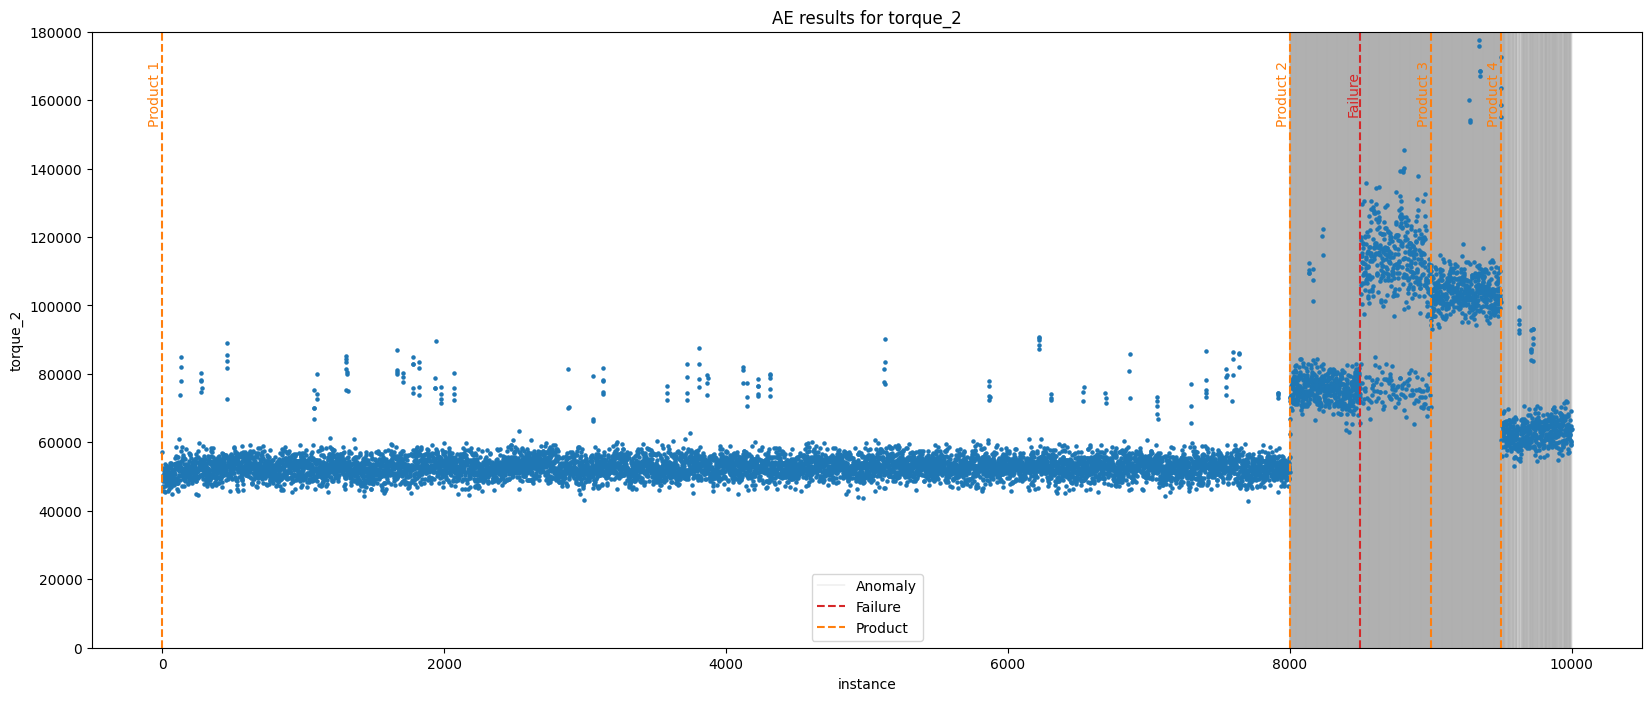

63/63 [==============================] - 0s 466us/step


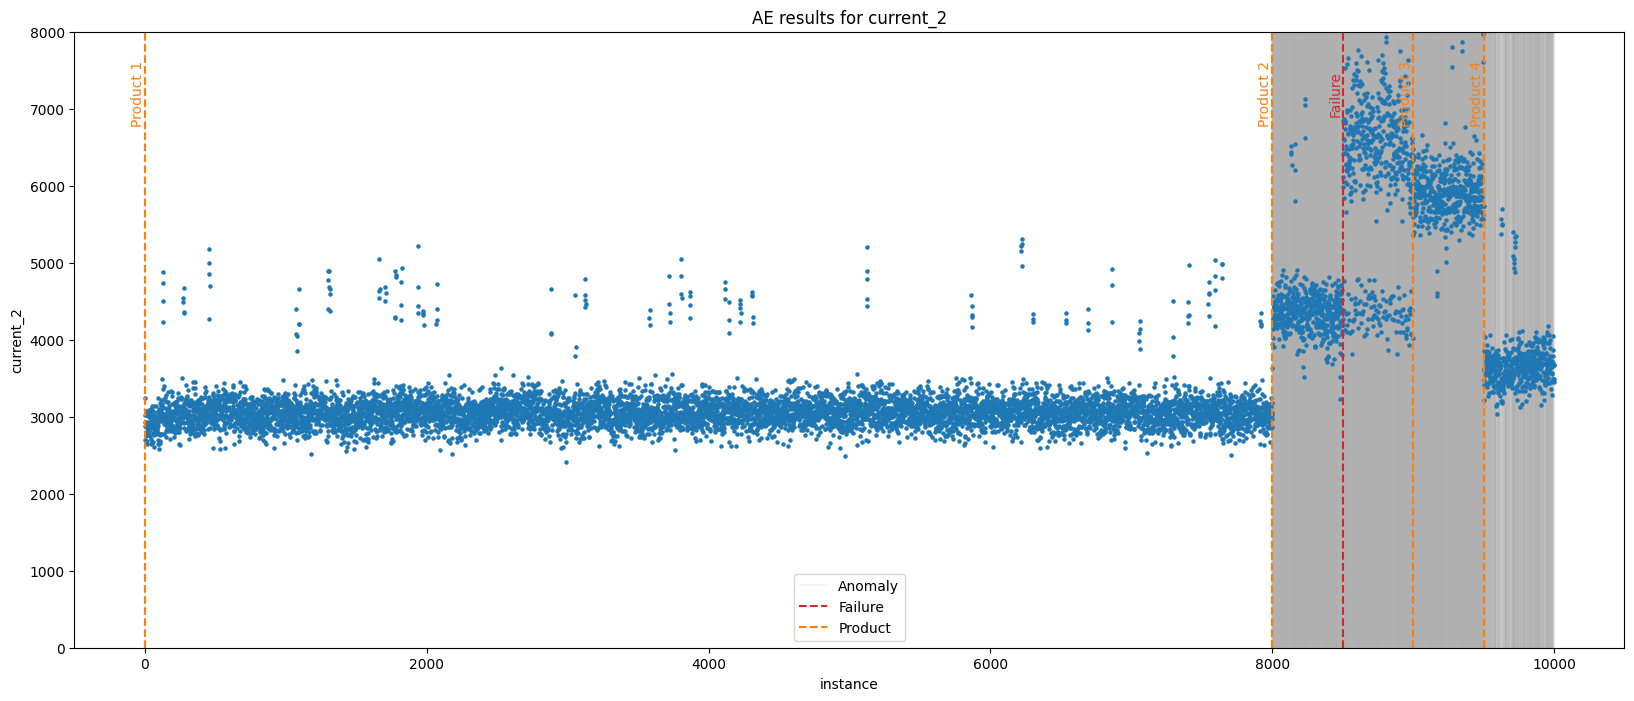

In [72]:
plot_outliers_in_signals_AE(df = df,
                  cols = ["torque", "current"],
                  stand = 2,
                 changes = [8000,8500, 9002, 9501])